### Predicting which outpatients are at high risk of being admitted to hospital for Chronic Heart Failure.
- Using DE-SynPUF inpatient and outpatient files downloaded from https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html
- Inpatient Claims 1,332,822 records
- Outpatient Claims 15,826,985 records

In [ ]:
# import and read intial file Michelle has transformed/merged from inpatient/outpatient recods, 
# use NaN for elements with no values
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

df = pd.read_csv("OpToIp_OpNoAdmsn_Merged_Reduced_agg_DiagCode_join_BenefTable.csv", na_values = ['no info', '.'],low_memory=False)

In [ ]:
#print(df.head(5))
print(df.shape) 

In [ ]:
#df.dtypes
print(df.columns)

In [ ]:
print(df.head(5))

In [ ]:
# removing duplicate rows, 1424410 removed
#df_rm_dup= df.drop_duplicates(['MEMBER_ID','CLM_ID','OPFROM_DT','OPDIAG1',
#            'OPDIAG2','OPDIAG3','OPDIAG4','OPDIAG5',
#       'OPDIAG6', 'OPDIAG7', 'OPDIAG8', 'OPDIAG9','OPDIAG10',
#       'OPPRCDR1', 'OPPRCDR2', 'OPPRCDR3', 'OPPRCDR4', 'OPPRCDR5',
#        'OPPRCDR6','OPADMTNG_DIAG','OPHCPCS1','OPHCPCS2','OPHCPCS3','OPHCPCS4','OPHCPCS5'], keep='first')
# print(df_rm_dup.shape)

# checked and no duplicates to remove so commment out this code

In [ ]:
#also delete duplicate DESYNPUF_ID before merge
#df_merge_subset = df_merge_subset.drop_duplicates(['DESYNPUF_ID'], keep='first')

In [ ]:
# looking at count of catagorical data
cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       'Median(days_op_to_ip)', 'HF label', 'BENE_SEX_IDENT_CD',
       'SP_STATE_CODE', 'BENE_RACE_CD', 'Age']
for name in cols:
    print(name,':')
    print(df[name].value_counts(),'\n')

In [ ]:
df_model=df[['1', '2', '3', '4', '5', '6', '7', '8', '9','10', '11', '12', '13', '14', '15',
             '16', '17', '18', '19','BENE_SEX_IDENT_CD','SP_STATE_CODE', 'BENE_RACE_CD', 'Age','HF label']]

In [ ]:
# rename HF label column so no space
df_model.rename(columns={'HF label':'HF_label','BENE_SEX_IDENT_CD':'BENE_SEX'}, inplace = True)
df_model.head(5)

### Exploratory Data Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_model['HF_label'].value_counts()

In [ ]:
sns.countplot(x='HF_label', data=df_model)

In [ ]:
# encode and write file for use
#Binary Encoding Catergorical Variables without Order
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['SP_STATE_CODE','BENE_RACE_CD'])
df_encoded = encoder.fit_transform(df_model)
df_encoded.head()

In [ ]:
#df_encoded.to_csv(r'C:\Users\barba\Documents\Jupyter Notebooks\healthcare_analytics_medicare_DESynPUF_dataset\project_modeling_imbal_data.csv')

### Balance classes

In [ ]:
# Class count
count_class_0, count_class_1 = df_model.HF_label.value_counts()

# Divide by class
df_class_0 = df_model[df_model['HF_label'] == 0]
df_class_1 = df_model[df_model['HF_label'] == 1]

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.HF_label.value_counts())

df_test_under.HF_label.value_counts().plot(kind='bar', title='Count (HF_label)');

In [ ]:
# 4280 frequency for race catagory
# {1:'White',2:'Black',3:'Other', 5:'Hispanic'}
sns.countplot(data=df_test_under,x='BENE_RACE_CD',hue='HF_label')

In [ ]:
sns.countplot(data=df_test_under,x='SP_STATE_CODE',hue='HF_label')

In [ ]:
# looking at count of catagorical data
cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19','BENE_SEX',
       'SP_STATE_CODE', 'BENE_RACE_CD', 'Age', 'HF_label']
for name in cols:
    print(name,':')
    print(df_test_under[name].value_counts(),'\n')

### Encode and Apply Model

In [713]:
import lightgbm as lgb
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

In [714]:
print(df_test_under.columns)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', 'BENE_SEX', 'SP_STATE_CODE',
       'BENE_RACE_CD', 'Age', 'HF_label'],
      dtype='object')


In [715]:
df_test_under.head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,BENE_SEX,SP_STATE_CODE,BENE_RACE_CD,Age,HF_label
428027,1,0,1,0,0,0,0,2,1,0,...,0,2,0,3,0,0,W,White,96,0
538365,1,3,7,4,4,0,3,1,1,4,...,0,8,1,3,0,0,M,White,75,0
1253534,0,3,8,6,0,5,7,2,0,0,...,0,9,1,7,0,0,W,White,87,0
556025,0,1,9,2,3,0,10,3,2,2,...,0,9,1,11,1,0,S,White,65,0
624594,1,0,2,0,1,4,9,0,2,5,...,0,8,0,5,0,0,N,White,67,0


In [716]:
#Binary Encoding Catergorical Variables without Order
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['SP_STATE_CODE','BENE_RACE_CD'])
df_encoded = encoder.fit_transform(df_test_under)
df_encoded.head()

,1,2,3,4,5,6,7,8,9,10,...,BENE_SEX,SP_STATE_CODE_0,SP_STATE_CODE_1,SP_STATE_CODE_2,SP_STATE_CODE_3,BENE_RACE_CD_0,BENE_RACE_CD_1,BENE_RACE_CD_2,Age,HF_label
428027,1,0,1,0,0,0,0,2,1,0,...,0,0,0,0,1,0,0,1,96,0
538365,1,3,7,4,4,0,3,1,1,4,...,0,0,0,1,0,0,0,1,75,0
1253534,0,3,8,6,0,5,7,2,0,0,...,0,0,0,0,1,0,0,1,87,0
556025,0,1,9,2,3,0,10,3,2,2,...,0,0,0,1,1,0,0,1,65,0
624594,1,0,2,0,1,4,9,0,2,5,...,0,0,1,0,0,0,0,1,67,0


In [717]:
print(df_encoded.columns)
#df_encoded.to_csv(r'C:\Users\barba\Documents\Jupyter Notebooks\healthcare_analytics_medicare_DESynPUF_dataset\project_modeling_bal_data.csv')

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', 'BENE_SEX', 'SP_STATE_CODE_0',
       'SP_STATE_CODE_1', 'SP_STATE_CODE_2', 'SP_STATE_CODE_3',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'Age',
       'HF_label'],
      dtype='object')


In [718]:
# split data for test/train
X = df_encoded.drop(['HF_label'], axis=1)
y = df_encoded['HF_label']
#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [719]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 70)
param_grid = {
    'n_estimators': [x for x in range(20, 100, 4)],
    'learning_rate': [0.05, 0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

C:\Users\barba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's l1: 0.49907	valid_0's binary_logloss: 0.691355	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498173	valid_0's binary_logloss: 0.689738	valid_0's auc: 0.591394
[3]	valid_0's l1: 0.497333	valid_0's binary_logloss: 0.688318	valid_0's auc: 0.591838
[4]	valid_0's l1: 0.49646	valid_0's binary_logloss: 0.686863	valid_0's auc: 0.596892
[5]	valid_0's l1: 0.495649	valid_0's binary_logloss: 0.685588	valid_0's auc: 0.599021
[6]	valid_0's l1: 0.494847	valid_0's binary_logloss: 0.684345	valid_0's auc: 0.602183
[7]	valid_0's l1: 0.494152	valid_0's binary_logloss: 0.683377	valid_0's auc: 0.60221
[8]	valid_0's l1: 0.493421	valid_0's binary_logloss: 0.682335	valid_0's auc: 0.60416
[9]	valid_0's l1: 0.492739	valid_0's binary_logloss: 0.681424	valid_0's auc: 0.604745
[10]	valid_0's l1: 0.492086	valid_0's binary_logloss: 0.680556	valid_0's auc: 0.60585
[11]	valid_0's l1: 0.491397	valid_0's binary_logloss: 0.679673	valid_0's auc: 0.607

[21]	valid_0's l1: 0.485655	valid_0's binary_logloss: 0.673429	valid_0's auc: 0.615837
[22]	valid_0's l1: 0.485295	valid_0's binary_logloss: 0.673159	valid_0's auc: 0.615923
[23]	valid_0's l1: 0.484892	valid_0's binary_logloss: 0.672773	valid_0's auc: 0.61678
[24]	valid_0's l1: 0.484534	valid_0's binary_logloss: 0.672499	valid_0's auc: 0.616884
Did not meet early stopping. Best iteration is:
[24]	valid_0's l1: 0.484534	valid_0's binary_logloss: 0.672499	valid_0's auc: 0.616884
[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	val

[17]	valid_0's l1: 0.488157	valid_0's binary_logloss: 0.675854	valid_0's auc: 0.613138
[18]	valid_0's l1: 0.487769	valid_0's binary_logloss: 0.675533	valid_0's auc: 0.612932
[19]	valid_0's l1: 0.487285	valid_0's binary_logloss: 0.675032	valid_0's auc: 0.613763
[20]	valid_0's l1: 0.486855	valid_0's binary_logloss: 0.674622	valid_0's auc: 0.614177
[21]	valid_0's l1: 0.486398	valid_0's binary_logloss: 0.674189	valid_0's auc: 0.614656
[22]	valid_0's l1: 0.485933	valid_0's binary_logloss: 0.673738	valid_0's auc: 0.615246
[23]	valid_0's l1: 0.485583	valid_0's binary_logloss: 0.673423	valid_0's auc: 0.615592
[24]	valid_0's l1: 0.485226	valid_0's binary_logloss: 0.673151	valid_0's auc: 0.61573
[25]	valid_0's l1: 0.484904	valid_0's binary_logloss: 0.672926	valid_0's auc: 0.615689
[26]	valid_0's l1: 0.484554	valid_0's binary_logloss: 0.672655	valid_0's auc: 0.615735
[27]	valid_0's l1: 0.484214	valid_0's binary_logloss: 0.672373	valid_0's auc: 0.616091
[28]	valid_0's l1: 0.483885	valid_0's binary

[19]	valid_0's l1: 0.487285	valid_0's binary_logloss: 0.675032	valid_0's auc: 0.613763
[20]	valid_0's l1: 0.486855	valid_0's binary_logloss: 0.674622	valid_0's auc: 0.614177
[21]	valid_0's l1: 0.486398	valid_0's binary_logloss: 0.674189	valid_0's auc: 0.614656
[22]	valid_0's l1: 0.485933	valid_0's binary_logloss: 0.673738	valid_0's auc: 0.615246
[23]	valid_0's l1: 0.485583	valid_0's binary_logloss: 0.673423	valid_0's auc: 0.615592
[24]	valid_0's l1: 0.485226	valid_0's binary_logloss: 0.673151	valid_0's auc: 0.61573
[25]	valid_0's l1: 0.484904	valid_0's binary_logloss: 0.672926	valid_0's auc: 0.615689
[26]	valid_0's l1: 0.484554	valid_0's binary_logloss: 0.672655	valid_0's auc: 0.615735
[27]	valid_0's l1: 0.484214	valid_0's binary_logloss: 0.672373	valid_0's auc: 0.616091
[28]	valid_0's l1: 0.483885	valid_0's binary_logloss: 0.672086	valid_0's auc: 0.616492
[29]	valid_0's l1: 0.483586	valid_0's binary_logloss: 0.671896	valid_0's auc: 0.616543
[30]	valid_0's l1: 0.483256	valid_0's binary

[22]	valid_0's l1: 0.485933	valid_0's binary_logloss: 0.673738	valid_0's auc: 0.615246
[23]	valid_0's l1: 0.485583	valid_0's binary_logloss: 0.673423	valid_0's auc: 0.615592
[24]	valid_0's l1: 0.485226	valid_0's binary_logloss: 0.673151	valid_0's auc: 0.61573
[25]	valid_0's l1: 0.484904	valid_0's binary_logloss: 0.672926	valid_0's auc: 0.615689
[26]	valid_0's l1: 0.484554	valid_0's binary_logloss: 0.672655	valid_0's auc: 0.615735
[27]	valid_0's l1: 0.484214	valid_0's binary_logloss: 0.672373	valid_0's auc: 0.616091
[28]	valid_0's l1: 0.483885	valid_0's binary_logloss: 0.672086	valid_0's auc: 0.616492
[29]	valid_0's l1: 0.483586	valid_0's binary_logloss: 0.671896	valid_0's auc: 0.616543
[30]	valid_0's l1: 0.483256	valid_0's binary_logloss: 0.671578	valid_0's auc: 0.617343
[31]	valid_0's l1: 0.482984	valid_0's binary_logloss: 0.671393	valid_0's auc: 0.617515
[32]	valid_0's l1: 0.482697	valid_0's binary_logloss: 0.671225	valid_0's auc: 0.617664
[33]	valid_0's l1: 0.482438	valid_0's binary

[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	valid_0's binary_logloss: 0.684239	valid_0's auc: 0.603267
[7]	valid_0's l1: 0.494048	valid_0's binary_logloss: 0.683103	valid_0's auc: 0.605438
[8]	valid_0's l1: 0.493362	valid_0's binary_logloss: 0.682145	valid_0's auc: 0.606645
[9]	valid_0's l1: 0.492662	valid_0's binary_logloss: 0.681176	valid_0's auc: 0.60836
[10]	valid_0's l1: 0.492021	valid_0's binary_logloss: 0.680349	valid_0's auc: 0.608993
[11]	valid_0's l1: 0.491449	valid_0's binary_logloss: 0.679633	valid_0's auc: 0.60

[17]	valid_0's l1: 0.487435	valid_0's binary_logloss: 0.675052	valid_0's auc: 0.614262
[18]	valid_0's l1: 0.486968	valid_0's binary_logloss: 0.674594	valid_0's auc: 0.61481
[19]	valid_0's l1: 0.486502	valid_0's binary_logloss: 0.674165	valid_0's auc: 0.615329
[20]	valid_0's l1: 0.486069	valid_0's binary_logloss: 0.673798	valid_0's auc: 0.615537
[21]	valid_0's l1: 0.485655	valid_0's binary_logloss: 0.673429	valid_0's auc: 0.615837
[22]	valid_0's l1: 0.485295	valid_0's binary_logloss: 0.673159	valid_0's auc: 0.615923
[23]	valid_0's l1: 0.484892	valid_0's binary_logloss: 0.672773	valid_0's auc: 0.61678
[24]	valid_0's l1: 0.484534	valid_0's binary_logloss: 0.672499	valid_0's auc: 0.616884
[25]	valid_0's l1: 0.484136	valid_0's binary_logloss: 0.672166	valid_0's auc: 0.61739
[26]	valid_0's l1: 0.483825	valid_0's binary_logloss: 0.671971	valid_0's auc: 0.617434
[27]	valid_0's l1: 0.483521	valid_0's binary_logloss: 0.671786	valid_0's auc: 0.617345
[28]	valid_0's l1: 0.483178	valid_0's binary_l

[44]	valid_0's l1: 0.479776	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.618086
[45]	valid_0's l1: 0.479625	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.617946
[46]	valid_0's l1: 0.479463	valid_0's binary_logloss: 0.670253	valid_0's auc: 0.617893
[47]	valid_0's l1: 0.479364	valid_0's binary_logloss: 0.670282	valid_0's auc: 0.61762
[48]	valid_0's l1: 0.479234	valid_0's binary_logloss: 0.67023	valid_0's auc: 0.617604
Did not meet early stopping. Best iteration is:
[48]	valid_0's l1: 0.479234	valid_0's binary_logloss: 0.67023	valid_0's auc: 0.617604
[1]	valid_0's l1: 0.498975	valid_0's binary_logloss: 0.691166	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497962	valid_0's binary_logloss: 0.689314	valid_0's auc: 0.599302
[3]	valid_0's l1: 0.496993	valid_0's binary_logloss: 0.687631	valid_0's auc: 0.602806
[4]	valid_0's l1: 0.496121	valid_0's binary_logloss: 0.686219	valid_0's auc: 0.602884
[5]	valid_0's l1: 0.495244	v

[1]	valid_0's l1: 0.49907	valid_0's binary_logloss: 0.691355	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498173	valid_0's binary_logloss: 0.689738	valid_0's auc: 0.591394
[3]	valid_0's l1: 0.497333	valid_0's binary_logloss: 0.688318	valid_0's auc: 0.591838
[4]	valid_0's l1: 0.49646	valid_0's binary_logloss: 0.686863	valid_0's auc: 0.596892
[5]	valid_0's l1: 0.495649	valid_0's binary_logloss: 0.685588	valid_0's auc: 0.599021
[6]	valid_0's l1: 0.494847	valid_0's binary_logloss: 0.684345	valid_0's auc: 0.602183
[7]	valid_0's l1: 0.494152	valid_0's binary_logloss: 0.683377	valid_0's auc: 0.60221
[8]	valid_0's l1: 0.493421	valid_0's binary_logloss: 0.682335	valid_0's auc: 0.60416
[9]	valid_0's l1: 0.492739	valid_0's binary_logloss: 0.681424	valid_0's auc: 0.604745
[10]	valid_0's l1: 0.492086	valid_0's binary_logloss: 0.680556	valid_0's auc: 0.60585
[11]	valid_0's l1: 0.491397	valid_0's binary_logloss: 0.679673	valid_0's auc: 0.607

[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	valid_0's binary_logloss: 0.684239	valid_0's auc: 0.603267
[7]	valid_0's l1: 0.494048	valid_0's binary_logloss: 0.683103	valid_0's auc: 0.605438
[8]	valid_0's l1: 0.493362	valid_0's binary_logloss: 0.682145	valid_0's auc: 0.606645
[9]	valid_0's l1: 0.492662	valid_0's binary_logloss: 0.681176	valid_0's auc: 0.60836
[10]	valid_0's l1: 0.492021	valid_0's binary_logloss: 0.680349	valid_0's auc: 0.608993
[11]	valid_0's l1: 0.491449	valid_0's binary_logloss: 0.679633	valid_0's auc: 0.60

[1]	valid_0's l1: 0.498975	valid_0's binary_logloss: 0.691166	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497962	valid_0's binary_logloss: 0.689314	valid_0's auc: 0.599302
[3]	valid_0's l1: 0.496993	valid_0's binary_logloss: 0.687631	valid_0's auc: 0.602806
[4]	valid_0's l1: 0.496121	valid_0's binary_logloss: 0.686219	valid_0's auc: 0.602884
[5]	valid_0's l1: 0.495244	valid_0's binary_logloss: 0.684815	valid_0's auc: 0.606443
[6]	valid_0's l1: 0.494431	valid_0's binary_logloss: 0.683614	valid_0's auc: 0.606748
[7]	valid_0's l1: 0.493616	valid_0's binary_logloss: 0.68242	valid_0's auc: 0.608492
[8]	valid_0's l1: 0.492858	valid_0's binary_logloss: 0.681381	valid_0's auc: 0.609297
[9]	valid_0's l1: 0.492152	valid_0's binary_logloss: 0.68045	valid_0's auc: 0.609775
[10]	valid_0's l1: 0.491445	valid_0's binary_logloss: 0.679559	valid_0's auc: 0.610236
[11]	valid_0's l1: 0.490802	valid_0's binary_logloss: 0.678809	valid_0's auc: 0.

[51]	valid_0's l1: 0.478774	valid_0's binary_logloss: 0.669174	valid_0's auc: 0.619793
[52]	valid_0's l1: 0.478656	valid_0's binary_logloss: 0.669134	valid_0's auc: 0.619837
[53]	valid_0's l1: 0.478572	valid_0's binary_logloss: 0.669206	valid_0's auc: 0.619667
Early stopping, best iteration is:
[48]	valid_0's l1: 0.479209	valid_0's binary_logloss: 0.669218	valid_0's auc: 0.619941
[1]	valid_0's l1: 0.49907	valid_0's binary_logloss: 0.691355	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498173	valid_0's binary_logloss: 0.689738	valid_0's auc: 0.591394
[3]	valid_0's l1: 0.497333	valid_0's binary_logloss: 0.688318	valid_0's auc: 0.591838
[4]	valid_0's l1: 0.49646	valid_0's binary_logloss: 0.686863	valid_0's auc: 0.596892
[5]	valid_0's l1: 0.495649	valid_0's binary_logloss: 0.685588	valid_0's auc: 0.599021
[6]	valid_0's l1: 0.494847	valid_0's binary_logloss: 0.684345	valid_0's auc: 0.602183
[7]	valid_0's l1: 0.494152	valid_0's binar

[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	valid_0's binary_logloss: 0.684239	valid_0's auc: 0.603267
[7]	valid_0's l1: 0.494048	valid_0's binary_logloss: 0.683103	valid_0's auc: 0.605438
[8]	valid_0's l1: 0.493362	valid_0's binary_logloss: 0.682145	valid_0's auc: 0.606645
[9]	valid_0's l1: 0.492662	valid_0's binary_logloss: 0.681176	valid_0's auc: 0.60836
[10]	valid_0's l1: 0.492021	valid_0's binary_logloss: 0.680349	valid_0's auc: 0.608993
[11]	valid_0's l1: 0.491449	valid_0's binary_logloss: 0.679633	valid_0's auc: 0.60

[48]	valid_0's l1: 0.479234	valid_0's binary_logloss: 0.67023	valid_0's auc: 0.617604
[49]	valid_0's l1: 0.479073	valid_0's binary_logloss: 0.670133	valid_0's auc: 0.617915
Early stopping, best iteration is:
[44]	valid_0's l1: 0.479776	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.618086
[1]	valid_0's l1: 0.498975	valid_0's binary_logloss: 0.691166	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497962	valid_0's binary_logloss: 0.689314	valid_0's auc: 0.599302
[3]	valid_0's l1: 0.496993	valid_0's binary_logloss: 0.687631	valid_0's auc: 0.602806
[4]	valid_0's l1: 0.496121	valid_0's binary_logloss: 0.686219	valid_0's auc: 0.602884
[5]	valid_0's l1: 0.495244	valid_0's binary_logloss: 0.684815	valid_0's auc: 0.606443
[6]	valid_0's l1: 0.494431	valid_0's binary_logloss: 0.683614	valid_0's auc: 0.606748
[7]	valid_0's l1: 0.493616	valid_0's binary_logloss: 0.68242	valid_0's auc: 0.608492
[8]	valid_0's l1: 0.492858	valid_0's binary

[1]	valid_0's l1: 0.49907	valid_0's binary_logloss: 0.691355	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498173	valid_0's binary_logloss: 0.689738	valid_0's auc: 0.591394
[3]	valid_0's l1: 0.497333	valid_0's binary_logloss: 0.688318	valid_0's auc: 0.591838
[4]	valid_0's l1: 0.49646	valid_0's binary_logloss: 0.686863	valid_0's auc: 0.596892
[5]	valid_0's l1: 0.495649	valid_0's binary_logloss: 0.685588	valid_0's auc: 0.599021
[6]	valid_0's l1: 0.494847	valid_0's binary_logloss: 0.684345	valid_0's auc: 0.602183
[7]	valid_0's l1: 0.494152	valid_0's binary_logloss: 0.683377	valid_0's auc: 0.60221
[8]	valid_0's l1: 0.493421	valid_0's binary_logloss: 0.682335	valid_0's auc: 0.60416
[9]	valid_0's l1: 0.492739	valid_0's binary_logloss: 0.681424	valid_0's auc: 0.604745
[10]	valid_0's l1: 0.492086	valid_0's binary_logloss: 0.680556	valid_0's auc: 0.60585
[11]	valid_0's l1: 0.491397	valid_0's binary_logloss: 0.679673	valid_0's auc: 0.607

[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	valid_0's binary_logloss: 0.684239	valid_0's auc: 0.603267
[7]	valid_0's l1: 0.494048	valid_0's binary_logloss: 0.683103	valid_0's auc: 0.605438
[8]	valid_0's l1: 0.493362	valid_0's binary_logloss: 0.682145	valid_0's auc: 0.606645
[9]	valid_0's l1: 0.492662	valid_0's binary_logloss: 0.681176	valid_0's auc: 0.60836
[10]	valid_0's l1: 0.492021	valid_0's binary_logloss: 0.680349	valid_0's auc: 0.608993
[11]	valid_0's l1: 0.491449	valid_0's binary_logloss: 0.679633	valid_0's auc: 0.60

[49]	valid_0's l1: 0.479073	valid_0's binary_logloss: 0.670133	valid_0's auc: 0.617915
Early stopping, best iteration is:
[44]	valid_0's l1: 0.479776	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.618086
[1]	valid_0's l1: 0.498975	valid_0's binary_logloss: 0.691166	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497962	valid_0's binary_logloss: 0.689314	valid_0's auc: 0.599302
[3]	valid_0's l1: 0.496993	valid_0's binary_logloss: 0.687631	valid_0's auc: 0.602806
[4]	valid_0's l1: 0.496121	valid_0's binary_logloss: 0.686219	valid_0's auc: 0.602884
[5]	valid_0's l1: 0.495244	valid_0's binary_logloss: 0.684815	valid_0's auc: 0.606443
[6]	valid_0's l1: 0.494431	valid_0's binary_logloss: 0.683614	valid_0's auc: 0.606748
[7]	valid_0's l1: 0.493616	valid_0's binary_logloss: 0.68242	valid_0's auc: 0.608492
[8]	valid_0's l1: 0.492858	valid_0's binary_logloss: 0.681381	valid_0's auc: 0.609297
[9]	valid_0's l1: 0.492152	valid_0's binary

[1]	valid_0's l1: 0.49907	valid_0's binary_logloss: 0.691355	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498173	valid_0's binary_logloss: 0.689738	valid_0's auc: 0.591394
[3]	valid_0's l1: 0.497333	valid_0's binary_logloss: 0.688318	valid_0's auc: 0.591838
[4]	valid_0's l1: 0.49646	valid_0's binary_logloss: 0.686863	valid_0's auc: 0.596892
[5]	valid_0's l1: 0.495649	valid_0's binary_logloss: 0.685588	valid_0's auc: 0.599021
[6]	valid_0's l1: 0.494847	valid_0's binary_logloss: 0.684345	valid_0's auc: 0.602183
[7]	valid_0's l1: 0.494152	valid_0's binary_logloss: 0.683377	valid_0's auc: 0.60221
[8]	valid_0's l1: 0.493421	valid_0's binary_logloss: 0.682335	valid_0's auc: 0.60416
[9]	valid_0's l1: 0.492739	valid_0's binary_logloss: 0.681424	valid_0's auc: 0.604745
[10]	valid_0's l1: 0.492086	valid_0's binary_logloss: 0.680556	valid_0's auc: 0.60585
[11]	valid_0's l1: 0.491397	valid_0's binary_logloss: 0.679673	valid_0's auc: 0.607

[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	valid_0's binary_logloss: 0.684239	valid_0's auc: 0.603267
[7]	valid_0's l1: 0.494048	valid_0's binary_logloss: 0.683103	valid_0's auc: 0.605438
[8]	valid_0's l1: 0.493362	valid_0's binary_logloss: 0.682145	valid_0's auc: 0.606645
[9]	valid_0's l1: 0.492662	valid_0's binary_logloss: 0.681176	valid_0's auc: 0.60836
[10]	valid_0's l1: 0.492021	valid_0's binary_logloss: 0.680349	valid_0's auc: 0.608993
[11]	valid_0's l1: 0.491449	valid_0's binary_logloss: 0.679633	valid_0's auc: 0.60

[40]	valid_0's l1: 0.480525	valid_0's binary_logloss: 0.670455	valid_0's auc: 0.61792
[41]	valid_0's l1: 0.480338	valid_0's binary_logloss: 0.670391	valid_0's auc: 0.618047
[42]	valid_0's l1: 0.48014	valid_0's binary_logloss: 0.670362	valid_0's auc: 0.61798
[43]	valid_0's l1: 0.479947	valid_0's binary_logloss: 0.670302	valid_0's auc: 0.618076
[44]	valid_0's l1: 0.479776	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.618086
[45]	valid_0's l1: 0.479625	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.617946
[46]	valid_0's l1: 0.479463	valid_0's binary_logloss: 0.670253	valid_0's auc: 0.617893
[47]	valid_0's l1: 0.479364	valid_0's binary_logloss: 0.670282	valid_0's auc: 0.61762
[48]	valid_0's l1: 0.479234	valid_0's binary_logloss: 0.67023	valid_0's auc: 0.617604
[49]	valid_0's l1: 0.479073	valid_0's binary_logloss: 0.670133	valid_0's auc: 0.617915
Early stopping, best iteration is:
[44]	valid_0's l1: 0.479776	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.618086
[1]	valid_0's

[43]	valid_0's l1: 0.480099	valid_0's binary_logloss: 0.669696	valid_0's auc: 0.619145
[44]	valid_0's l1: 0.479887	valid_0's binary_logloss: 0.669546	valid_0's auc: 0.619422
[45]	valid_0's l1: 0.47971	valid_0's binary_logloss: 0.669453	valid_0's auc: 0.619544
[46]	valid_0's l1: 0.479537	valid_0's binary_logloss: 0.669379	valid_0's auc: 0.619613
[47]	valid_0's l1: 0.479409	valid_0's binary_logloss: 0.669358	valid_0's auc: 0.619483
[48]	valid_0's l1: 0.479209	valid_0's binary_logloss: 0.669218	valid_0's auc: 0.619941
[49]	valid_0's l1: 0.479056	valid_0's binary_logloss: 0.669203	valid_0's auc: 0.619873
[50]	valid_0's l1: 0.478905	valid_0's binary_logloss: 0.669187	valid_0's auc: 0.619856
[51]	valid_0's l1: 0.478774	valid_0's binary_logloss: 0.669174	valid_0's auc: 0.619793
[52]	valid_0's l1: 0.478656	valid_0's binary_logloss: 0.669134	valid_0's auc: 0.619837
[53]	valid_0's l1: 0.478572	valid_0's binary_logloss: 0.669206	valid_0's auc: 0.619667
Early stopping, best iteration is:
[48]	vali

[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	valid_0's binary_logloss: 0.684239	valid_0's auc: 0.603267
[7]	valid_0's l1: 0.494048	valid_0's binary_logloss: 0.683103	valid_0's auc: 0.605438
[8]	valid_0's l1: 0.493362	valid_0's binary_logloss: 0.682145	valid_0's auc: 0.606645
[9]	valid_0's l1: 0.492662	valid_0's binary_logloss: 0.681176	valid_0's auc: 0.60836
[10]	valid_0's l1: 0.492021	valid_0's binary_logloss: 0.680349	valid_0's auc: 0.608993
[11]	valid_0's l1: 0.491449	valid_0's binary_logloss: 0.679633	valid_0's auc: 0.60

[1]	valid_0's l1: 0.498975	valid_0's binary_logloss: 0.691166	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497962	valid_0's binary_logloss: 0.689314	valid_0's auc: 0.599302
[3]	valid_0's l1: 0.496993	valid_0's binary_logloss: 0.687631	valid_0's auc: 0.602806
[4]	valid_0's l1: 0.496121	valid_0's binary_logloss: 0.686219	valid_0's auc: 0.602884
[5]	valid_0's l1: 0.495244	valid_0's binary_logloss: 0.684815	valid_0's auc: 0.606443
[6]	valid_0's l1: 0.494431	valid_0's binary_logloss: 0.683614	valid_0's auc: 0.606748
[7]	valid_0's l1: 0.493616	valid_0's binary_logloss: 0.68242	valid_0's auc: 0.608492
[8]	valid_0's l1: 0.492858	valid_0's binary_logloss: 0.681381	valid_0's auc: 0.609297
[9]	valid_0's l1: 0.492152	valid_0's binary_logloss: 0.68045	valid_0's auc: 0.609775
[10]	valid_0's l1: 0.491445	valid_0's binary_logloss: 0.679559	valid_0's auc: 0.610236
[11]	valid_0's l1: 0.490802	valid_0's binary_logloss: 0.678809	valid_0's auc: 0.

[53]	valid_0's l1: 0.478572	valid_0's binary_logloss: 0.669206	valid_0's auc: 0.619667
Early stopping, best iteration is:
[48]	valid_0's l1: 0.479209	valid_0's binary_logloss: 0.669218	valid_0's auc: 0.619941
[1]	valid_0's l1: 0.49907	valid_0's binary_logloss: 0.691355	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498173	valid_0's binary_logloss: 0.689738	valid_0's auc: 0.591394
[3]	valid_0's l1: 0.497333	valid_0's binary_logloss: 0.688318	valid_0's auc: 0.591838
[4]	valid_0's l1: 0.49646	valid_0's binary_logloss: 0.686863	valid_0's auc: 0.596892
[5]	valid_0's l1: 0.495649	valid_0's binary_logloss: 0.685588	valid_0's auc: 0.599021
[6]	valid_0's l1: 0.494847	valid_0's binary_logloss: 0.684345	valid_0's auc: 0.602183
[7]	valid_0's l1: 0.494152	valid_0's binary_logloss: 0.683377	valid_0's auc: 0.60221
[8]	valid_0's l1: 0.493421	valid_0's binary_logloss: 0.682335	valid_0's auc: 0.60416
[9]	valid_0's l1: 0.492739	valid_0's binary_lo

[1]	valid_0's l1: 0.499033	valid_0's binary_logloss: 0.69128	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689573	valid_0's auc: 0.596222
[3]	valid_0's l1: 0.497194	valid_0's binary_logloss: 0.688016	valid_0's auc: 0.59882
[4]	valid_0's l1: 0.496328	valid_0's binary_logloss: 0.686588	valid_0's auc: 0.600348
[5]	valid_0's l1: 0.495528	valid_0's binary_logloss: 0.685297	valid_0's auc: 0.603209
[6]	valid_0's l1: 0.494817	valid_0's binary_logloss: 0.684239	valid_0's auc: 0.603267
[7]	valid_0's l1: 0.494048	valid_0's binary_logloss: 0.683103	valid_0's auc: 0.605438
[8]	valid_0's l1: 0.493362	valid_0's binary_logloss: 0.682145	valid_0's auc: 0.606645
[9]	valid_0's l1: 0.492662	valid_0's binary_logloss: 0.681176	valid_0's auc: 0.60836
[10]	valid_0's l1: 0.492021	valid_0's binary_logloss: 0.680349	valid_0's auc: 0.608993
[11]	valid_0's l1: 0.491449	valid_0's binary_logloss: 0.679633	valid_0's auc: 0.60

[42]	valid_0's l1: 0.48014	valid_0's binary_logloss: 0.670362	valid_0's auc: 0.61798
[43]	valid_0's l1: 0.479947	valid_0's binary_logloss: 0.670302	valid_0's auc: 0.618076
[44]	valid_0's l1: 0.479776	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.618086
[45]	valid_0's l1: 0.479625	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.617946
[46]	valid_0's l1: 0.479463	valid_0's binary_logloss: 0.670253	valid_0's auc: 0.617893
[47]	valid_0's l1: 0.479364	valid_0's binary_logloss: 0.670282	valid_0's auc: 0.61762
[48]	valid_0's l1: 0.479234	valid_0's binary_logloss: 0.67023	valid_0's auc: 0.617604
[49]	valid_0's l1: 0.479073	valid_0's binary_logloss: 0.670133	valid_0's auc: 0.617915
Early stopping, best iteration is:
[44]	valid_0's l1: 0.479776	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.618086
[1]	valid_0's l1: 0.498975	valid_0's binary_logloss: 0.691166	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497962	valid_0's bi

[48]	valid_0's l1: 0.479209	valid_0's binary_logloss: 0.669218	valid_0's auc: 0.619941
[49]	valid_0's l1: 0.479056	valid_0's binary_logloss: 0.669203	valid_0's auc: 0.619873
[50]	valid_0's l1: 0.478905	valid_0's binary_logloss: 0.669187	valid_0's auc: 0.619856
[51]	valid_0's l1: 0.478774	valid_0's binary_logloss: 0.669174	valid_0's auc: 0.619793
[52]	valid_0's l1: 0.478656	valid_0's binary_logloss: 0.669134	valid_0's auc: 0.619837
[53]	valid_0's l1: 0.478572	valid_0's binary_logloss: 0.669206	valid_0's auc: 0.619667
Early stopping, best iteration is:
[48]	valid_0's l1: 0.479209	valid_0's binary_logloss: 0.669218	valid_0's auc: 0.619941
[1]	valid_0's l1: 0.498137	valid_0's binary_logloss: 0.689688	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496424	valid_0's binary_logloss: 0.686899	valid_0's auc: 0.591557
[3]	valid_0's l1: 0.494769	valid_0's binary_logloss: 0.684338	valid_0's auc: 0.598288
[4]	valid_0's l1: 0.493229	valid_0's 

[1]	valid_0's l1: 0.497947	valid_0's binary_logloss: 0.689313	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496046	valid_0's binary_logloss: 0.686129	valid_0's auc: 0.601586
[3]	valid_0's l1: 0.494292	valid_0's binary_logloss: 0.683416	valid_0's auc: 0.606448
[4]	valid_0's l1: 0.492768	valid_0's binary_logloss: 0.68133	valid_0's auc: 0.607641
[5]	valid_0's l1: 0.491295	valid_0's binary_logloss: 0.679428	valid_0's auc: 0.6098
[6]	valid_0's l1: 0.489998	valid_0's binary_logloss: 0.677924	valid_0's auc: 0.610256
[7]	valid_0's l1: 0.488798	valid_0's binary_logloss: 0.676588	valid_0's auc: 0.611667
[8]	valid_0's l1: 0.48774	valid_0's binary_logloss: 0.675484	valid_0's auc: 0.6128
[9]	valid_0's l1: 0.486884	valid_0's binary_logloss: 0.674784	valid_0's auc: 0.612551
[10]	valid_0's l1: 0.485918	valid_0's binary_logloss: 0.67396	valid_0's auc: 0.613241
[11]	valid_0's l1: 0.485014	valid_0's binary_logloss: 0.673121	valid_0's auc: 0.61479

[23]	valid_0's l1: 0.478545	valid_0's binary_logloss: 0.669013	valid_0's auc: 0.620559
[24]	valid_0's l1: 0.478348	valid_0's binary_logloss: 0.669159	valid_0's auc: 0.619976
[25]	valid_0's l1: 0.477887	valid_0's binary_logloss: 0.668899	valid_0's auc: 0.620639
[26]	valid_0's l1: 0.477532	valid_0's binary_logloss: 0.668823	valid_0's auc: 0.620816
[27]	valid_0's l1: 0.477216	valid_0's binary_logloss: 0.668752	valid_0's auc: 0.621022
[28]	valid_0's l1: 0.476981	valid_0's binary_logloss: 0.668803	valid_0's auc: 0.620753
Did not meet early stopping. Best iteration is:
[28]	valid_0's l1: 0.476981	valid_0's binary_logloss: 0.668803	valid_0's auc: 0.620753
[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.49317

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.498062	valid_0's binary_logloss: 0.689537	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496315	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.596599
[3]	valid_0's l1: 0.494742	valid_0's binary_logloss: 0.684236	valid_0's auc: 0.600968
[4]	valid_0's l1: 0.493178	valid_0's binary_logloss: 0.681947	valid_0's auc: 0.605591
[5]	valid_0's l1: 0.491864	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.607139
[6]	valid_0's l1: 0.490527	valid_0's binary_logloss: 0.678518	valid_0's auc: 0.611063
[7]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.611194
[8]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.676424	valid_0's auc: 0.611455
[9]	valid_0's l1: 0.487539	valid_0's binary_logloss: 0.675513	valid_0's auc: 0.612037
[10]	valid_0's l1: 0.48655	valid_0's binary_logloss: 0.674473	valid_0's auc: 0.613482
[11]	valid_0's l1: 0.485664	valid_0's binary_logloss: 0.673689	valid_0's auc: 0.

[1]	valid_0's l1: 0.497434	valid_0's binary_logloss: 0.688438	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495159	valid_0's binary_logloss: 0.684806	valid_0's auc: 0.600981
[3]	valid_0's l1: 0.493073	valid_0's binary_logloss: 0.681796	valid_0's auc: 0.606312
[4]	valid_0's l1: 0.491288	valid_0's binary_logloss: 0.679593	valid_0's auc: 0.606481
[5]	valid_0's l1: 0.489784	valid_0's binary_logloss: 0.67785	valid_0's auc: 0.608153
[6]	valid_0's l1: 0.488356	valid_0's binary_logloss: 0.676467	valid_0's auc: 0.608428
[7]	valid_0's l1: 0.487276	valid_0's binary_logloss: 0.675598	valid_0's auc: 0.607911
[8]	valid_0's l1: 0.486123	valid_0's binary_logloss: 0.674567	valid_0's auc: 0.60925
[9]	valid_0's l1: 0.485071	valid_0's binary_logloss: 0.67363	valid_0's auc: 0.611294
[10]	valid_0's l1: 0.484151	valid_0's binary_logloss: 0.673033	valid_0's auc: 0.611665
[11]	valid_0's l1: 0.483285	valid_0's binary_logloss: 0.672448	valid_0's auc: 0.6

[23]	valid_0's l1: 0.477365	valid_0's binary_logloss: 0.670194	valid_0's auc: 0.616941
[24]	valid_0's l1: 0.47698	valid_0's binary_logloss: 0.670023	valid_0's auc: 0.617342
[25]	valid_0's l1: 0.476918	valid_0's binary_logloss: 0.670263	valid_0's auc: 0.616796
[26]	valid_0's l1: 0.476604	valid_0's binary_logloss: 0.670036	valid_0's auc: 0.617317
[27]	valid_0's l1: 0.476394	valid_0's binary_logloss: 0.670073	valid_0's auc: 0.617775
[28]	valid_0's l1: 0.476137	valid_0's binary_logloss: 0.670002	valid_0's auc: 0.617848
Did not meet early stopping. Best iteration is:
[28]	valid_0's l1: 0.476137	valid_0's binary_logloss: 0.670002	valid_0's auc: 0.617848
[1]	valid_0's l1: 0.497578	valid_0's binary_logloss: 0.688715	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495391	valid_0's binary_logloss: 0.685203	valid_0's auc: 0.598993
[3]	valid_0's l1: 0.493618	valid_0's binary_logloss: 0.682684	valid_0's auc: 0.600687
[4]	valid_0's l1: 0.491821

[1]	valid_0's l1: 0.497578	valid_0's binary_logloss: 0.688715	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495391	valid_0's binary_logloss: 0.685203	valid_0's auc: 0.598993
[3]	valid_0's l1: 0.493618	valid_0's binary_logloss: 0.682684	valid_0's auc: 0.600687
[4]	valid_0's l1: 0.491821	valid_0's binary_logloss: 0.680276	valid_0's auc: 0.605998
[5]	valid_0's l1: 0.490348	valid_0's binary_logloss: 0.678486	valid_0's auc: 0.607904
[6]	valid_0's l1: 0.489032	valid_0's binary_logloss: 0.677171	valid_0's auc: 0.607195
[7]	valid_0's l1: 0.487785	valid_0's binary_logloss: 0.675921	valid_0's auc: 0.608444
[8]	valid_0's l1: 0.486655	valid_0's binary_logloss: 0.67485	valid_0's auc: 0.610402
[9]	valid_0's l1: 0.485559	valid_0's binary_logloss: 0.673796	valid_0's auc: 0.611921
[10]	valid_0's l1: 0.484699	valid_0's binary_logloss: 0.673239	valid_0's auc: 0.611724
[11]	valid_0's l1: 0.483773	valid_0's binary_logloss: 0.672392	valid_0's auc: 0.

[20]	valid_0's l1: 0.478943	valid_0's binary_logloss: 0.670352	valid_0's auc: 0.615121
[21]	valid_0's l1: 0.478619	valid_0's binary_logloss: 0.670398	valid_0's auc: 0.614901
[22]	valid_0's l1: 0.478271	valid_0's binary_logloss: 0.670333	valid_0's auc: 0.615198
[23]	valid_0's l1: 0.477968	valid_0's binary_logloss: 0.670254	valid_0's auc: 0.615509
[24]	valid_0's l1: 0.477772	valid_0's binary_logloss: 0.670382	valid_0's auc: 0.615474
[25]	valid_0's l1: 0.477644	valid_0's binary_logloss: 0.670476	valid_0's auc: 0.615075
[26]	valid_0's l1: 0.477429	valid_0's binary_logloss: 0.670449	valid_0's auc: 0.615517
[27]	valid_0's l1: 0.477182	valid_0's binary_logloss: 0.670374	valid_0's auc: 0.615582
[28]	valid_0's l1: 0.476988	valid_0's binary_logloss: 0.67029	valid_0's auc: 0.615839
Early stopping, best iteration is:
[23]	valid_0's l1: 0.477968	valid_0's binary_logloss: 0.670254	valid_0's auc: 0.615509
[1]	valid_0's l1: 0.497671	valid_0's binary_logloss: 0.688904	valid_0's auc: 0.588949
Training u

[1]	valid_0's l1: 0.497671	valid_0's binary_logloss: 0.688904	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495409	valid_0's binary_logloss: 0.685238	valid_0's auc: 0.599484
[3]	valid_0's l1: 0.493386	valid_0's binary_logloss: 0.682283	valid_0's auc: 0.60427
[4]	valid_0's l1: 0.491769	valid_0's binary_logloss: 0.680199	valid_0's auc: 0.606104
[5]	valid_0's l1: 0.489935	valid_0's binary_logloss: 0.67785	valid_0's auc: 0.610771
[6]	valid_0's l1: 0.488454	valid_0's binary_logloss: 0.676261	valid_0's auc: 0.611613
[7]	valid_0's l1: 0.487215	valid_0's binary_logloss: 0.67506	valid_0's auc: 0.612681
[8]	valid_0's l1: 0.486188	valid_0's binary_logloss: 0.674319	valid_0's auc: 0.612664
[9]	valid_0's l1: 0.485154	valid_0's binary_logloss: 0.673525	valid_0's auc: 0.613561
[10]	valid_0's l1: 0.484147	valid_0's binary_logloss: 0.672742	valid_0's auc: 0.614784
[11]	valid_0's l1: 0.483366	valid_0's binary_logloss: 0.672316	valid_0's auc: 0.6

[1]	valid_0's l1: 0.497434	valid_0's binary_logloss: 0.688438	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495159	valid_0's binary_logloss: 0.684806	valid_0's auc: 0.600981
[3]	valid_0's l1: 0.493073	valid_0's binary_logloss: 0.681796	valid_0's auc: 0.606312
[4]	valid_0's l1: 0.491288	valid_0's binary_logloss: 0.679593	valid_0's auc: 0.606481
[5]	valid_0's l1: 0.489784	valid_0's binary_logloss: 0.67785	valid_0's auc: 0.608153
[6]	valid_0's l1: 0.488356	valid_0's binary_logloss: 0.676467	valid_0's auc: 0.608428
[7]	valid_0's l1: 0.487276	valid_0's binary_logloss: 0.675598	valid_0's auc: 0.607911
[8]	valid_0's l1: 0.486123	valid_0's binary_logloss: 0.674567	valid_0's auc: 0.60925
[9]	valid_0's l1: 0.485071	valid_0's binary_logloss: 0.67363	valid_0's auc: 0.611294
[10]	valid_0's l1: 0.484151	valid_0's binary_logloss: 0.673033	valid_0's auc: 0.611665
[11]	valid_0's l1: 0.483285	valid_0's binary_logloss: 0.672448	valid_0's auc: 0.6

[22]	valid_0's l1: 0.477748	valid_0's binary_logloss: 0.670371	valid_0's auc: 0.616495
[23]	valid_0's l1: 0.477365	valid_0's binary_logloss: 0.670194	valid_0's auc: 0.616941
[24]	valid_0's l1: 0.47698	valid_0's binary_logloss: 0.670023	valid_0's auc: 0.617342
[25]	valid_0's l1: 0.476918	valid_0's binary_logloss: 0.670263	valid_0's auc: 0.616796
[26]	valid_0's l1: 0.476604	valid_0's binary_logloss: 0.670036	valid_0's auc: 0.617317
[27]	valid_0's l1: 0.476394	valid_0's binary_logloss: 0.670073	valid_0's auc: 0.617775
[28]	valid_0's l1: 0.476137	valid_0's binary_logloss: 0.670002	valid_0's auc: 0.617848
[29]	valid_0's l1: 0.476015	valid_0's binary_logloss: 0.670108	valid_0's auc: 0.617966
[30]	valid_0's l1: 0.47599	valid_0's binary_logloss: 0.67035	valid_0's auc: 0.617415
[31]	valid_0's l1: 0.475824	valid_0's binary_logloss: 0.670399	valid_0's auc: 0.617429
[32]	valid_0's l1: 0.475672	valid_0's binary_logloss: 0.670432	valid_0's auc: 0.617401
[33]	valid_0's l1: 0.47561	valid_0's binary_lo

[1]	valid_0's l1: 0.497578	valid_0's binary_logloss: 0.688715	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495391	valid_0's binary_logloss: 0.685203	valid_0's auc: 0.598993
[3]	valid_0's l1: 0.493618	valid_0's binary_logloss: 0.682684	valid_0's auc: 0.600687
[4]	valid_0's l1: 0.491821	valid_0's binary_logloss: 0.680276	valid_0's auc: 0.605998
[5]	valid_0's l1: 0.490348	valid_0's binary_logloss: 0.678486	valid_0's auc: 0.607904
[6]	valid_0's l1: 0.489032	valid_0's binary_logloss: 0.677171	valid_0's auc: 0.607195
[7]	valid_0's l1: 0.487785	valid_0's binary_logloss: 0.675921	valid_0's auc: 0.608444
[8]	valid_0's l1: 0.486655	valid_0's binary_logloss: 0.67485	valid_0's auc: 0.610402
[9]	valid_0's l1: 0.485559	valid_0's binary_logloss: 0.673796	valid_0's auc: 0.611921
[10]	valid_0's l1: 0.484699	valid_0's binary_logloss: 0.673239	valid_0's auc: 0.611724
[11]	valid_0's l1: 0.483773	valid_0's binary_logloss: 0.672392	valid_0's auc: 0.

[23]	valid_0's l1: 0.477968	valid_0's binary_logloss: 0.670254	valid_0's auc: 0.615509
[24]	valid_0's l1: 0.477772	valid_0's binary_logloss: 0.670382	valid_0's auc: 0.615474
[25]	valid_0's l1: 0.477644	valid_0's binary_logloss: 0.670476	valid_0's auc: 0.615075
[26]	valid_0's l1: 0.477429	valid_0's binary_logloss: 0.670449	valid_0's auc: 0.615517
[27]	valid_0's l1: 0.477182	valid_0's binary_logloss: 0.670374	valid_0's auc: 0.615582
[28]	valid_0's l1: 0.476988	valid_0's binary_logloss: 0.67029	valid_0's auc: 0.615839
Early stopping, best iteration is:
[23]	valid_0's l1: 0.477968	valid_0's binary_logloss: 0.670254	valid_0's auc: 0.615509
[1]	valid_0's l1: 0.497671	valid_0's binary_logloss: 0.688904	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495409	valid_0's binary_logloss: 0.685238	valid_0's auc: 0.599484
[3]	valid_0's l1: 0.493386	valid_0's binary_logloss: 0.682283	valid_0's auc: 0.60427
[4]	valid_0's l1: 0.491769	valid_0's bi

[1]	valid_0's l1: 0.497671	valid_0's binary_logloss: 0.688904	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495409	valid_0's binary_logloss: 0.685238	valid_0's auc: 0.599484
[3]	valid_0's l1: 0.493386	valid_0's binary_logloss: 0.682283	valid_0's auc: 0.60427
[4]	valid_0's l1: 0.491769	valid_0's binary_logloss: 0.680199	valid_0's auc: 0.606104
[5]	valid_0's l1: 0.489935	valid_0's binary_logloss: 0.67785	valid_0's auc: 0.610771
[6]	valid_0's l1: 0.488454	valid_0's binary_logloss: 0.676261	valid_0's auc: 0.611613
[7]	valid_0's l1: 0.487215	valid_0's binary_logloss: 0.67506	valid_0's auc: 0.612681
[8]	valid_0's l1: 0.486188	valid_0's binary_logloss: 0.674319	valid_0's auc: 0.612664
[9]	valid_0's l1: 0.485154	valid_0's binary_logloss: 0.673525	valid_0's auc: 0.613561
[10]	valid_0's l1: 0.484147	valid_0's binary_logloss: 0.672742	valid_0's auc: 0.614784
[11]	valid_0's l1: 0.483366	valid_0's binary_logloss: 0.672316	valid_0's auc: 0.6

[18]	valid_0's l1: 0.479126	valid_0's binary_logloss: 0.670215	valid_0's auc: 0.618475
[19]	valid_0's l1: 0.478703	valid_0's binary_logloss: 0.670184	valid_0's auc: 0.618371
[20]	valid_0's l1: 0.478393	valid_0's binary_logloss: 0.670153	valid_0's auc: 0.618144
[21]	valid_0's l1: 0.478068	valid_0's binary_logloss: 0.670178	valid_0's auc: 0.61833
Early stopping, best iteration is:
[16]	valid_0's l1: 0.480012	valid_0's binary_logloss: 0.670347	valid_0's auc: 0.618513
[1]	valid_0's l1: 0.497434	valid_0's binary_logloss: 0.688438	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495159	valid_0's binary_logloss: 0.684806	valid_0's auc: 0.600981
[3]	valid_0's l1: 0.493073	valid_0's binary_logloss: 0.681796	valid_0's auc: 0.606312
[4]	valid_0's l1: 0.491288	valid_0's binary_logloss: 0.679593	valid_0's auc: 0.606481
[5]	valid_0's l1: 0.489784	valid_0's binary_logloss: 0.67785	valid_0's auc: 0.608153
[6]	valid_0's l1: 0.488356	valid_0's bina

[23]	valid_0's l1: 0.477365	valid_0's binary_logloss: 0.670194	valid_0's auc: 0.616941
[24]	valid_0's l1: 0.47698	valid_0's binary_logloss: 0.670023	valid_0's auc: 0.617342
[25]	valid_0's l1: 0.476918	valid_0's binary_logloss: 0.670263	valid_0's auc: 0.616796
[26]	valid_0's l1: 0.476604	valid_0's binary_logloss: 0.670036	valid_0's auc: 0.617317
[27]	valid_0's l1: 0.476394	valid_0's binary_logloss: 0.670073	valid_0's auc: 0.617775
[28]	valid_0's l1: 0.476137	valid_0's binary_logloss: 0.670002	valid_0's auc: 0.617848
[29]	valid_0's l1: 0.476015	valid_0's binary_logloss: 0.670108	valid_0's auc: 0.617966
[30]	valid_0's l1: 0.47599	valid_0's binary_logloss: 0.67035	valid_0's auc: 0.617415
[31]	valid_0's l1: 0.475824	valid_0's binary_logloss: 0.670399	valid_0's auc: 0.617429
[32]	valid_0's l1: 0.475672	valid_0's binary_logloss: 0.670432	valid_0's auc: 0.617401
[33]	valid_0's l1: 0.47561	valid_0's binary_logloss: 0.670682	valid_0's auc: 0.617045
Early stopping, best iteration is:
[28]	valid_0

[1]	valid_0's l1: 0.497578	valid_0's binary_logloss: 0.688715	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495391	valid_0's binary_logloss: 0.685203	valid_0's auc: 0.598993
[3]	valid_0's l1: 0.493618	valid_0's binary_logloss: 0.682684	valid_0's auc: 0.600687
[4]	valid_0's l1: 0.491821	valid_0's binary_logloss: 0.680276	valid_0's auc: 0.605998
[5]	valid_0's l1: 0.490348	valid_0's binary_logloss: 0.678486	valid_0's auc: 0.607904
[6]	valid_0's l1: 0.489032	valid_0's binary_logloss: 0.677171	valid_0's auc: 0.607195
[7]	valid_0's l1: 0.487785	valid_0's binary_logloss: 0.675921	valid_0's auc: 0.608444
[8]	valid_0's l1: 0.486655	valid_0's binary_logloss: 0.67485	valid_0's auc: 0.610402
[9]	valid_0's l1: 0.485559	valid_0's binary_logloss: 0.673796	valid_0's auc: 0.611921
[10]	valid_0's l1: 0.484699	valid_0's binary_logloss: 0.673239	valid_0's auc: 0.611724
[11]	valid_0's l1: 0.483773	valid_0's binary_logloss: 0.672392	valid_0's auc: 0.

[18]	valid_0's l1: 0.47969	valid_0's binary_logloss: 0.670431	valid_0's auc: 0.615066
[19]	valid_0's l1: 0.47927	valid_0's binary_logloss: 0.670355	valid_0's auc: 0.615302
[20]	valid_0's l1: 0.478943	valid_0's binary_logloss: 0.670352	valid_0's auc: 0.615121
[21]	valid_0's l1: 0.478619	valid_0's binary_logloss: 0.670398	valid_0's auc: 0.614901
[22]	valid_0's l1: 0.478271	valid_0's binary_logloss: 0.670333	valid_0's auc: 0.615198
[23]	valid_0's l1: 0.477968	valid_0's binary_logloss: 0.670254	valid_0's auc: 0.615509
[24]	valid_0's l1: 0.477772	valid_0's binary_logloss: 0.670382	valid_0's auc: 0.615474
[25]	valid_0's l1: 0.477644	valid_0's binary_logloss: 0.670476	valid_0's auc: 0.615075
[26]	valid_0's l1: 0.477429	valid_0's binary_logloss: 0.670449	valid_0's auc: 0.615517
[27]	valid_0's l1: 0.477182	valid_0's binary_logloss: 0.670374	valid_0's auc: 0.615582
[28]	valid_0's l1: 0.476988	valid_0's binary_logloss: 0.67029	valid_0's auc: 0.615839
Early stopping, best iteration is:
[23]	valid_

[1]	valid_0's l1: 0.497671	valid_0's binary_logloss: 0.688904	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495409	valid_0's binary_logloss: 0.685238	valid_0's auc: 0.599484
[3]	valid_0's l1: 0.493386	valid_0's binary_logloss: 0.682283	valid_0's auc: 0.60427
[4]	valid_0's l1: 0.491769	valid_0's binary_logloss: 0.680199	valid_0's auc: 0.606104
[5]	valid_0's l1: 0.489935	valid_0's binary_logloss: 0.67785	valid_0's auc: 0.610771
[6]	valid_0's l1: 0.488454	valid_0's binary_logloss: 0.676261	valid_0's auc: 0.611613
[7]	valid_0's l1: 0.487215	valid_0's binary_logloss: 0.67506	valid_0's auc: 0.612681
[8]	valid_0's l1: 0.486188	valid_0's binary_logloss: 0.674319	valid_0's auc: 0.612664
[9]	valid_0's l1: 0.485154	valid_0's binary_logloss: 0.673525	valid_0's auc: 0.613561
[10]	valid_0's l1: 0.484147	valid_0's binary_logloss: 0.672742	valid_0's auc: 0.614784
[11]	valid_0's l1: 0.483366	valid_0's binary_logloss: 0.672316	valid_0's auc: 0.6

[20]	valid_0's l1: 0.478393	valid_0's binary_logloss: 0.670153	valid_0's auc: 0.618144
[21]	valid_0's l1: 0.478068	valid_0's binary_logloss: 0.670178	valid_0's auc: 0.61833
Early stopping, best iteration is:
[16]	valid_0's l1: 0.480012	valid_0's binary_logloss: 0.670347	valid_0's auc: 0.618513
[1]	valid_0's l1: 0.497434	valid_0's binary_logloss: 0.688438	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495159	valid_0's binary_logloss: 0.684806	valid_0's auc: 0.600981
[3]	valid_0's l1: 0.493073	valid_0's binary_logloss: 0.681796	valid_0's auc: 0.606312
[4]	valid_0's l1: 0.491288	valid_0's binary_logloss: 0.679593	valid_0's auc: 0.606481
[5]	valid_0's l1: 0.489784	valid_0's binary_logloss: 0.67785	valid_0's auc: 0.608153
[6]	valid_0's l1: 0.488356	valid_0's binary_logloss: 0.676467	valid_0's auc: 0.608428
[7]	valid_0's l1: 0.487276	valid_0's binary_logloss: 0.675598	valid_0's auc: 0.607911
[8]	valid_0's l1: 0.486123	valid_0's binary

[18]	valid_0's l1: 0.47758	valid_0's binary_logloss: 0.670516	valid_0's auc: 0.61585
[19]	valid_0's l1: 0.477316	valid_0's binary_logloss: 0.670667	valid_0's auc: 0.615691
[20]	valid_0's l1: 0.476936	valid_0's binary_logloss: 0.670571	valid_0's auc: 0.616107
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.476936	valid_0's binary_logloss: 0.670571	valid_0's auc: 0.616107
[1]	valid_0's l1: 0.497094	valid_0's binary_logloss: 0.687926	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494515	valid_0's binary_logloss: 0.683961	valid_0's auc: 0.59912
[3]	valid_0's l1: 0.492219	valid_0's binary_logloss: 0.680758	valid_0's auc: 0.605904
[4]	valid_0's l1: 0.490408	valid_0's binary_logloss: 0.678596	valid_0's auc: 0.608773
[5]	valid_0's l1: 0.488901	valid_0's binary_logloss: 0.677031	valid_0's auc: 0.608227
[6]	valid_0's l1: 0.487382	valid_0's binary_logloss: 0.675578	valid_0's auc: 0.609524
[7]	valid_0's l1: 0.486144	vali

[1]	valid_0's l1: 0.497206	valid_0's binary_logloss: 0.688154	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494557	valid_0's binary_logloss: 0.684027	valid_0's auc: 0.599947
[3]	valid_0's l1: 0.492161	valid_0's binary_logloss: 0.680713	valid_0's auc: 0.605388
[4]	valid_0's l1: 0.490373	valid_0's binary_logloss: 0.678638	valid_0's auc: 0.606781
[5]	valid_0's l1: 0.488481	valid_0's binary_logloss: 0.676483	valid_0's auc: 0.610204
[6]	valid_0's l1: 0.487029	valid_0's binary_logloss: 0.675272	valid_0's auc: 0.610065
[7]	valid_0's l1: 0.485469	valid_0's binary_logloss: 0.673747	valid_0's auc: 0.613216
[8]	valid_0's l1: 0.484346	valid_0's binary_logloss: 0.672959	valid_0's auc: 0.614031
[9]	valid_0's l1: 0.48331	valid_0's binary_logloss: 0.672373	valid_0's auc: 0.614163
[10]	valid_0's l1: 0.482349	valid_0's binary_logloss: 0.6718	valid_0's auc: 0.614855
[11]	valid_0's l1: 0.481441	valid_0's binary_logloss: 0.671272	valid_0's auc: 0.6

[1]	valid_0's l1: 0.497094	valid_0's binary_logloss: 0.687926	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494515	valid_0's binary_logloss: 0.683961	valid_0's auc: 0.59912
[3]	valid_0's l1: 0.492219	valid_0's binary_logloss: 0.680758	valid_0's auc: 0.605904
[4]	valid_0's l1: 0.490408	valid_0's binary_logloss: 0.678596	valid_0's auc: 0.608773
[5]	valid_0's l1: 0.488901	valid_0's binary_logloss: 0.677031	valid_0's auc: 0.608227
[6]	valid_0's l1: 0.487382	valid_0's binary_logloss: 0.675578	valid_0's auc: 0.609524
[7]	valid_0's l1: 0.486144	valid_0's binary_logloss: 0.674486	valid_0's auc: 0.611083
[8]	valid_0's l1: 0.485034	valid_0's binary_logloss: 0.673646	valid_0's auc: 0.611916
[9]	valid_0's l1: 0.484047	valid_0's binary_logloss: 0.672985	valid_0's auc: 0.612773
[10]	valid_0's l1: 0.483145	valid_0's binary_logloss: 0.672484	valid_0's auc: 0.6126
[11]	valid_0's l1: 0.482287	valid_0's binary_logloss: 0.671943	valid_0's auc: 0.61

[1]	valid_0's l1: 0.497206	valid_0's binary_logloss: 0.688154	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494557	valid_0's binary_logloss: 0.684027	valid_0's auc: 0.599947
[3]	valid_0's l1: 0.492161	valid_0's binary_logloss: 0.680713	valid_0's auc: 0.605388
[4]	valid_0's l1: 0.490373	valid_0's binary_logloss: 0.678638	valid_0's auc: 0.606781
[5]	valid_0's l1: 0.488481	valid_0's binary_logloss: 0.676483	valid_0's auc: 0.610204
[6]	valid_0's l1: 0.487029	valid_0's binary_logloss: 0.675272	valid_0's auc: 0.610065
[7]	valid_0's l1: 0.485469	valid_0's binary_logloss: 0.673747	valid_0's auc: 0.613216
[8]	valid_0's l1: 0.484346	valid_0's binary_logloss: 0.672959	valid_0's auc: 0.614031
[9]	valid_0's l1: 0.48331	valid_0's binary_logloss: 0.672373	valid_0's auc: 0.614163
[10]	valid_0's l1: 0.482349	valid_0's binary_logloss: 0.6718	valid_0's auc: 0.614855
[11]	valid_0's l1: 0.481441	valid_0's binary_logloss: 0.671272	valid_0's auc: 0.6

[19]	valid_0's l1: 0.477316	valid_0's binary_logloss: 0.670667	valid_0's auc: 0.615691
[20]	valid_0's l1: 0.476936	valid_0's binary_logloss: 0.670571	valid_0's auc: 0.616107
Early stopping, best iteration is:
[15]	valid_0's l1: 0.478604	valid_0's binary_logloss: 0.67018	valid_0's auc: 0.616755
[1]	valid_0's l1: 0.497094	valid_0's binary_logloss: 0.687926	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494515	valid_0's binary_logloss: 0.683961	valid_0's auc: 0.59912
[3]	valid_0's l1: 0.492219	valid_0's binary_logloss: 0.680758	valid_0's auc: 0.605904
[4]	valid_0's l1: 0.490408	valid_0's binary_logloss: 0.678596	valid_0's auc: 0.608773
[5]	valid_0's l1: 0.488901	valid_0's binary_logloss: 0.677031	valid_0's auc: 0.608227
[6]	valid_0's l1: 0.487382	valid_0's binary_logloss: 0.675578	valid_0's auc: 0.609524
[7]	valid_0's l1: 0.486144	valid_0's binary_logloss: 0.674486	valid_0's auc: 0.611083
[8]	valid_0's l1: 0.485034	valid_0's binary_

[1]	valid_0's l1: 0.497206	valid_0's binary_logloss: 0.688154	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494557	valid_0's binary_logloss: 0.684027	valid_0's auc: 0.599947
[3]	valid_0's l1: 0.492161	valid_0's binary_logloss: 0.680713	valid_0's auc: 0.605388
[4]	valid_0's l1: 0.490373	valid_0's binary_logloss: 0.678638	valid_0's auc: 0.606781
[5]	valid_0's l1: 0.488481	valid_0's binary_logloss: 0.676483	valid_0's auc: 0.610204
[6]	valid_0's l1: 0.487029	valid_0's binary_logloss: 0.675272	valid_0's auc: 0.610065
[7]	valid_0's l1: 0.485469	valid_0's binary_logloss: 0.673747	valid_0's auc: 0.613216
[8]	valid_0's l1: 0.484346	valid_0's binary_logloss: 0.672959	valid_0's auc: 0.614031
[9]	valid_0's l1: 0.48331	valid_0's binary_logloss: 0.672373	valid_0's auc: 0.614163
[10]	valid_0's l1: 0.482349	valid_0's binary_logloss: 0.6718	valid_0's auc: 0.614855
[11]	valid_0's l1: 0.481441	valid_0's binary_logloss: 0.671272	valid_0's auc: 0.6

[17]	valid_0's l1: 0.477892	valid_0's binary_logloss: 0.6704	valid_0's auc: 0.615925
[18]	valid_0's l1: 0.47758	valid_0's binary_logloss: 0.670516	valid_0's auc: 0.61585
[19]	valid_0's l1: 0.477316	valid_0's binary_logloss: 0.670667	valid_0's auc: 0.615691
[20]	valid_0's l1: 0.476936	valid_0's binary_logloss: 0.670571	valid_0's auc: 0.616107
Early stopping, best iteration is:
[15]	valid_0's l1: 0.478604	valid_0's binary_logloss: 0.67018	valid_0's auc: 0.616755
[1]	valid_0's l1: 0.497094	valid_0's binary_logloss: 0.687926	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494515	valid_0's binary_logloss: 0.683961	valid_0's auc: 0.59912
[3]	valid_0's l1: 0.492219	valid_0's binary_logloss: 0.680758	valid_0's auc: 0.605904
[4]	valid_0's l1: 0.490408	valid_0's binary_logloss: 0.678596	valid_0's auc: 0.608773
[5]	valid_0's l1: 0.488901	valid_0's binary_logloss: 0.677031	valid_0's auc: 0.608227
[6]	valid_0's l1: 0.487382	valid_0's binary_lo

[1]	valid_0's l1: 0.497206	valid_0's binary_logloss: 0.688154	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494557	valid_0's binary_logloss: 0.684027	valid_0's auc: 0.599947
[3]	valid_0's l1: 0.492161	valid_0's binary_logloss: 0.680713	valid_0's auc: 0.605388
[4]	valid_0's l1: 0.490373	valid_0's binary_logloss: 0.678638	valid_0's auc: 0.606781
[5]	valid_0's l1: 0.488481	valid_0's binary_logloss: 0.676483	valid_0's auc: 0.610204
[6]	valid_0's l1: 0.487029	valid_0's binary_logloss: 0.675272	valid_0's auc: 0.610065
[7]	valid_0's l1: 0.485469	valid_0's binary_logloss: 0.673747	valid_0's auc: 0.613216
[8]	valid_0's l1: 0.484346	valid_0's binary_logloss: 0.672959	valid_0's auc: 0.614031
[9]	valid_0's l1: 0.48331	valid_0's binary_logloss: 0.672373	valid_0's auc: 0.614163
[10]	valid_0's l1: 0.482349	valid_0's binary_logloss: 0.6718	valid_0's auc: 0.614855
[11]	valid_0's l1: 0.481441	valid_0's binary_logloss: 0.671272	valid_0's auc: 0.6

[19]	valid_0's l1: 0.477316	valid_0's binary_logloss: 0.670667	valid_0's auc: 0.615691
[20]	valid_0's l1: 0.476936	valid_0's binary_logloss: 0.670571	valid_0's auc: 0.616107
Early stopping, best iteration is:
[15]	valid_0's l1: 0.478604	valid_0's binary_logloss: 0.67018	valid_0's auc: 0.616755
[1]	valid_0's l1: 0.497094	valid_0's binary_logloss: 0.687926	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494515	valid_0's binary_logloss: 0.683961	valid_0's auc: 0.59912
[3]	valid_0's l1: 0.492219	valid_0's binary_logloss: 0.680758	valid_0's auc: 0.605904
[4]	valid_0's l1: 0.490408	valid_0's binary_logloss: 0.678596	valid_0's auc: 0.608773
[5]	valid_0's l1: 0.488901	valid_0's binary_logloss: 0.677031	valid_0's auc: 0.608227
[6]	valid_0's l1: 0.487382	valid_0's binary_logloss: 0.675578	valid_0's auc: 0.609524
[7]	valid_0's l1: 0.486144	valid_0's binary_logloss: 0.674486	valid_0's auc: 0.611083
[8]	valid_0's l1: 0.485034	valid_0's binary_

[22]	valid_0's l1: 0.477121	valid_0's binary_logloss: 0.670644	valid_0's auc: 0.617087
[23]	valid_0's l1: 0.476861	valid_0's binary_logloss: 0.670681	valid_0's auc: 0.616899
[24]	valid_0's l1: 0.47665	valid_0's binary_logloss: 0.670773	valid_0's auc: 0.617099
Early stopping, best iteration is:
[19]	valid_0's l1: 0.477798	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.61792
[1]	valid_0's l1: 0.497206	valid_0's binary_logloss: 0.688154	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494557	valid_0's binary_logloss: 0.684027	valid_0's auc: 0.599947
[3]	valid_0's l1: 0.492161	valid_0's binary_logloss: 0.680713	valid_0's auc: 0.605388
[4]	valid_0's l1: 0.490373	valid_0's binary_logloss: 0.678638	valid_0's auc: 0.606781
[5]	valid_0's l1: 0.488481	valid_0's binary_logloss: 0.676483	valid_0's auc: 0.610204
[6]	valid_0's l1: 0.487029	valid_0's binary_logloss: 0.675272	valid_0's auc: 0.610065
[7]	valid_0's l1: 0.485469	valid_0's binar

[1]	valid_0's l1: 0.496921	valid_0's binary_logloss: 0.687597	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494389	valid_0's binary_logloss: 0.683755	valid_0's auc: 0.60043
[3]	valid_0's l1: 0.491938	valid_0's binary_logloss: 0.680373	valid_0's auc: 0.606165
[4]	valid_0's l1: 0.489895	valid_0's binary_logloss: 0.678037	valid_0's auc: 0.607714
[5]	valid_0's l1: 0.488144	valid_0's binary_logloss: 0.676128	valid_0's auc: 0.61029
[6]	valid_0's l1: 0.486705	valid_0's binary_logloss: 0.674834	valid_0's auc: 0.611182
[7]	valid_0's l1: 0.485453	valid_0's binary_logloss: 0.673799	valid_0's auc: 0.612376
[8]	valid_0's l1: 0.484342	valid_0's binary_logloss: 0.673003	valid_0's auc: 0.612793
[9]	valid_0's l1: 0.483213	valid_0's binary_logloss: 0.672262	valid_0's auc: 0.613651
[10]	valid_0's l1: 0.482082	valid_0's binary_logloss: 0.671477	valid_0's auc: 0.614708
[11]	valid_0's l1: 0.481271	valid_0's binary_logloss: 0.671078	valid_0's auc: 0.

[23]	valid_0's l1: 0.476861	valid_0's binary_logloss: 0.670681	valid_0's auc: 0.616899
[24]	valid_0's l1: 0.47665	valid_0's binary_logloss: 0.670773	valid_0's auc: 0.617099
Early stopping, best iteration is:
[19]	valid_0's l1: 0.477798	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.61792
[1]	valid_0's l1: 0.497206	valid_0's binary_logloss: 0.688154	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494557	valid_0's binary_logloss: 0.684027	valid_0's auc: 0.599947
[3]	valid_0's l1: 0.492161	valid_0's binary_logloss: 0.680713	valid_0's auc: 0.605388
[4]	valid_0's l1: 0.490373	valid_0's binary_logloss: 0.678638	valid_0's auc: 0.606781
[5]	valid_0's l1: 0.488481	valid_0's binary_logloss: 0.676483	valid_0's auc: 0.610204
[6]	valid_0's l1: 0.487029	valid_0's binary_logloss: 0.675272	valid_0's auc: 0.610065
[7]	valid_0's l1: 0.485469	valid_0's binary_logloss: 0.673747	valid_0's auc: 0.613216
[8]	valid_0's l1: 0.484346	valid_0's binary

[1]	valid_0's l1: 0.496921	valid_0's binary_logloss: 0.687597	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494389	valid_0's binary_logloss: 0.683755	valid_0's auc: 0.60043
[3]	valid_0's l1: 0.491938	valid_0's binary_logloss: 0.680373	valid_0's auc: 0.606165
[4]	valid_0's l1: 0.489895	valid_0's binary_logloss: 0.678037	valid_0's auc: 0.607714
[5]	valid_0's l1: 0.488144	valid_0's binary_logloss: 0.676128	valid_0's auc: 0.61029
[6]	valid_0's l1: 0.486705	valid_0's binary_logloss: 0.674834	valid_0's auc: 0.611182
[7]	valid_0's l1: 0.485453	valid_0's binary_logloss: 0.673799	valid_0's auc: 0.612376
[8]	valid_0's l1: 0.484342	valid_0's binary_logloss: 0.673003	valid_0's auc: 0.612793
[9]	valid_0's l1: 0.483213	valid_0's binary_logloss: 0.672262	valid_0's auc: 0.613651
[10]	valid_0's l1: 0.482082	valid_0's binary_logloss: 0.671477	valid_0's auc: 0.614708
[11]	valid_0's l1: 0.481271	valid_0's binary_logloss: 0.671078	valid_0's auc: 0.

[16]	valid_0's l1: 0.479068	valid_0's binary_logloss: 0.670594	valid_0's auc: 0.616227
[17]	valid_0's l1: 0.478544	valid_0's binary_logloss: 0.670411	valid_0's auc: 0.617215
[18]	valid_0's l1: 0.478283	valid_0's binary_logloss: 0.670518	valid_0's auc: 0.616776
[19]	valid_0's l1: 0.477798	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.61792
[20]	valid_0's l1: 0.477551	valid_0's binary_logloss: 0.670445	valid_0's auc: 0.617422
[21]	valid_0's l1: 0.477333	valid_0's binary_logloss: 0.670552	valid_0's auc: 0.616986
[22]	valid_0's l1: 0.477121	valid_0's binary_logloss: 0.670644	valid_0's auc: 0.617087
[23]	valid_0's l1: 0.476861	valid_0's binary_logloss: 0.670681	valid_0's auc: 0.616899
[24]	valid_0's l1: 0.47665	valid_0's binary_logloss: 0.670773	valid_0's auc: 0.617099
Early stopping, best iteration is:
[19]	valid_0's l1: 0.477798	valid_0's binary_logloss: 0.670271	valid_0's auc: 0.61792
[1]	valid_0's l1: 0.496741	valid_0's binary_logloss: 0.687438	valid_0's auc: 0.588949
Training unt

[1]	valid_0's l1: 0.49661	valid_0's binary_logloss: 0.687171	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493553	valid_0's binary_logloss: 0.682522	valid_0's auc: 0.603998
[3]	valid_0's l1: 0.491228	valid_0's binary_logloss: 0.679554	valid_0's auc: 0.606526
[4]	valid_0's l1: 0.488976	valid_0's binary_logloss: 0.676877	valid_0's auc: 0.61052
[5]	valid_0's l1: 0.486914	valid_0's binary_logloss: 0.674673	valid_0's auc: 0.61436
[6]	valid_0's l1: 0.485598	valid_0's binary_logloss: 0.673859	valid_0's auc: 0.612928
[7]	valid_0's l1: 0.484381	valid_0's binary_logloss: 0.673096	valid_0's auc: 0.613436
[8]	valid_0's l1: 0.483379	valid_0's binary_logloss: 0.672501	valid_0's auc: 0.614094
[9]	valid_0's l1: 0.482402	valid_0's binary_logloss: 0.671972	valid_0's auc: 0.614647
[10]	valid_0's l1: 0.481376	valid_0's binary_logloss: 0.671229	valid_0's auc: 0.616406
[11]	valid_0's l1: 0.480552	valid_0's binary_logloss: 0.670976	valid_0's auc: 0.61

[1]	valid_0's l1: 0.49641	valid_0's binary_logloss: 0.68679	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493323	valid_0's binary_logloss: 0.682188	valid_0's auc: 0.604369
[3]	valid_0's l1: 0.490775	valid_0's binary_logloss: 0.67907	valid_0's auc: 0.606688
[4]	valid_0's l1: 0.488841	valid_0's binary_logloss: 0.677126	valid_0's auc: 0.606886
[5]	valid_0's l1: 0.487033	valid_0's binary_logloss: 0.675586	valid_0's auc: 0.607849
[6]	valid_0's l1: 0.485352	valid_0's binary_logloss: 0.674235	valid_0's auc: 0.609937
[7]	valid_0's l1: 0.483876	valid_0's binary_logloss: 0.672822	valid_0's auc: 0.613195
[8]	valid_0's l1: 0.482716	valid_0's binary_logloss: 0.672043	valid_0's auc: 0.614569
[9]	valid_0's l1: 0.481758	valid_0's binary_logloss: 0.671644	valid_0's auc: 0.614315
[10]	valid_0's l1: 0.480987	valid_0's binary_logloss: 0.671391	valid_0's auc: 0.613639
[11]	valid_0's l1: 0.480274	valid_0's binary_logloss: 0.671088	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496741	valid_0's binary_logloss: 0.687438	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493841	valid_0's binary_logloss: 0.683142	valid_0's auc: 0.598506
[3]	valid_0's l1: 0.491269	valid_0's binary_logloss: 0.679823	valid_0's auc: 0.603805
[4]	valid_0's l1: 0.489068	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.608074
[5]	valid_0's l1: 0.487333	valid_0's binary_logloss: 0.675733	valid_0's auc: 0.609542
[6]	valid_0's l1: 0.485651	valid_0's binary_logloss: 0.674321	valid_0's auc: 0.611183
[7]	valid_0's l1: 0.484171	valid_0's binary_logloss: 0.673195	valid_0's auc: 0.612275
[8]	valid_0's l1: 0.483079	valid_0's binary_logloss: 0.672616	valid_0's auc: 0.61236
[9]	valid_0's l1: 0.482062	valid_0's binary_logloss: 0.672011	valid_0's auc: 0.61334
[10]	valid_0's l1: 0.481078	valid_0's binary_logloss: 0.671532	valid_0's auc: 0.614288
[11]	valid_0's l1: 0.48032	valid_0's binary_logloss: 0.671436	valid_0's auc: 0.6

[1]	valid_0's l1: 0.49661	valid_0's binary_logloss: 0.687171	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493553	valid_0's binary_logloss: 0.682522	valid_0's auc: 0.603998
[3]	valid_0's l1: 0.491228	valid_0's binary_logloss: 0.679554	valid_0's auc: 0.606526
[4]	valid_0's l1: 0.488976	valid_0's binary_logloss: 0.676877	valid_0's auc: 0.61052
[5]	valid_0's l1: 0.486914	valid_0's binary_logloss: 0.674673	valid_0's auc: 0.61436
[6]	valid_0's l1: 0.485598	valid_0's binary_logloss: 0.673859	valid_0's auc: 0.612928
[7]	valid_0's l1: 0.484381	valid_0's binary_logloss: 0.673096	valid_0's auc: 0.613436
[8]	valid_0's l1: 0.483379	valid_0's binary_logloss: 0.672501	valid_0's auc: 0.614094
[9]	valid_0's l1: 0.482402	valid_0's binary_logloss: 0.671972	valid_0's auc: 0.614647
[10]	valid_0's l1: 0.481376	valid_0's binary_logloss: 0.671229	valid_0's auc: 0.616406
[11]	valid_0's l1: 0.480552	valid_0's binary_logloss: 0.670976	valid_0's auc: 0.61

[1]	valid_0's l1: 0.49641	valid_0's binary_logloss: 0.68679	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493323	valid_0's binary_logloss: 0.682188	valid_0's auc: 0.604369
[3]	valid_0's l1: 0.490775	valid_0's binary_logloss: 0.67907	valid_0's auc: 0.606688
[4]	valid_0's l1: 0.488841	valid_0's binary_logloss: 0.677126	valid_0's auc: 0.606886
[5]	valid_0's l1: 0.487033	valid_0's binary_logloss: 0.675586	valid_0's auc: 0.607849
[6]	valid_0's l1: 0.485352	valid_0's binary_logloss: 0.674235	valid_0's auc: 0.609937
[7]	valid_0's l1: 0.483876	valid_0's binary_logloss: 0.672822	valid_0's auc: 0.613195
[8]	valid_0's l1: 0.482716	valid_0's binary_logloss: 0.672043	valid_0's auc: 0.614569
[9]	valid_0's l1: 0.481758	valid_0's binary_logloss: 0.671644	valid_0's auc: 0.614315
[10]	valid_0's l1: 0.480987	valid_0's binary_logloss: 0.671391	valid_0's auc: 0.613639
[11]	valid_0's l1: 0.480274	valid_0's binary_logloss: 0.671088	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496741	valid_0's binary_logloss: 0.687438	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493841	valid_0's binary_logloss: 0.683142	valid_0's auc: 0.598506
[3]	valid_0's l1: 0.491269	valid_0's binary_logloss: 0.679823	valid_0's auc: 0.603805
[4]	valid_0's l1: 0.489068	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.608074
[5]	valid_0's l1: 0.487333	valid_0's binary_logloss: 0.675733	valid_0's auc: 0.609542
[6]	valid_0's l1: 0.485651	valid_0's binary_logloss: 0.674321	valid_0's auc: 0.611183
[7]	valid_0's l1: 0.484171	valid_0's binary_logloss: 0.673195	valid_0's auc: 0.612275
[8]	valid_0's l1: 0.483079	valid_0's binary_logloss: 0.672616	valid_0's auc: 0.61236
[9]	valid_0's l1: 0.482062	valid_0's binary_logloss: 0.672011	valid_0's auc: 0.61334
[10]	valid_0's l1: 0.481078	valid_0's binary_logloss: 0.671532	valid_0's auc: 0.614288
[11]	valid_0's l1: 0.48032	valid_0's binary_logloss: 0.671436	valid_0's auc: 0.6

[19]	valid_0's l1: 0.476353	valid_0's binary_logloss: 0.670722	valid_0's auc: 0.61529
Early stopping, best iteration is:
[14]	valid_0's l1: 0.478067	valid_0's binary_logloss: 0.669992	valid_0's auc: 0.616239
[1]	valid_0's l1: 0.49661	valid_0's binary_logloss: 0.687171	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493553	valid_0's binary_logloss: 0.682522	valid_0's auc: 0.603998
[3]	valid_0's l1: 0.491228	valid_0's binary_logloss: 0.679554	valid_0's auc: 0.606526
[4]	valid_0's l1: 0.488976	valid_0's binary_logloss: 0.676877	valid_0's auc: 0.61052
[5]	valid_0's l1: 0.486914	valid_0's binary_logloss: 0.674673	valid_0's auc: 0.61436
[6]	valid_0's l1: 0.485598	valid_0's binary_logloss: 0.673859	valid_0's auc: 0.612928
[7]	valid_0's l1: 0.484381	valid_0's binary_logloss: 0.673096	valid_0's auc: 0.613436
[8]	valid_0's l1: 0.483379	valid_0's binary_logloss: 0.672501	valid_0's auc: 0.614094
[9]	valid_0's l1: 0.482402	valid_0's binary_log

[1]	valid_0's l1: 0.49641	valid_0's binary_logloss: 0.68679	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493323	valid_0's binary_logloss: 0.682188	valid_0's auc: 0.604369
[3]	valid_0's l1: 0.490775	valid_0's binary_logloss: 0.67907	valid_0's auc: 0.606688
[4]	valid_0's l1: 0.488841	valid_0's binary_logloss: 0.677126	valid_0's auc: 0.606886
[5]	valid_0's l1: 0.487033	valid_0's binary_logloss: 0.675586	valid_0's auc: 0.607849
[6]	valid_0's l1: 0.485352	valid_0's binary_logloss: 0.674235	valid_0's auc: 0.609937
[7]	valid_0's l1: 0.483876	valid_0's binary_logloss: 0.672822	valid_0's auc: 0.613195
[8]	valid_0's l1: 0.482716	valid_0's binary_logloss: 0.672043	valid_0's auc: 0.614569
[9]	valid_0's l1: 0.481758	valid_0's binary_logloss: 0.671644	valid_0's auc: 0.614315
[10]	valid_0's l1: 0.480987	valid_0's binary_logloss: 0.671391	valid_0's auc: 0.613639
[11]	valid_0's l1: 0.480274	valid_0's binary_logloss: 0.671088	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496741	valid_0's binary_logloss: 0.687438	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493841	valid_0's binary_logloss: 0.683142	valid_0's auc: 0.598506
[3]	valid_0's l1: 0.491269	valid_0's binary_logloss: 0.679823	valid_0's auc: 0.603805
[4]	valid_0's l1: 0.489068	valid_0's binary_logloss: 0.677413	valid_0's auc: 0.608074
[5]	valid_0's l1: 0.487333	valid_0's binary_logloss: 0.675733	valid_0's auc: 0.609542
[6]	valid_0's l1: 0.485651	valid_0's binary_logloss: 0.674321	valid_0's auc: 0.611183
[7]	valid_0's l1: 0.484171	valid_0's binary_logloss: 0.673195	valid_0's auc: 0.612275
[8]	valid_0's l1: 0.483079	valid_0's binary_logloss: 0.672616	valid_0's auc: 0.61236
[9]	valid_0's l1: 0.482062	valid_0's binary_logloss: 0.672011	valid_0's auc: 0.61334
[10]	valid_0's l1: 0.481078	valid_0's binary_logloss: 0.671532	valid_0's auc: 0.614288
[11]	valid_0's l1: 0.48032	valid_0's binary_logloss: 0.671436	valid_0's auc: 0.6

[1]	valid_0's l1: 0.49661	valid_0's binary_logloss: 0.687171	valid_0's auc: 0.59126
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493553	valid_0's binary_logloss: 0.682522	valid_0's auc: 0.603998
[3]	valid_0's l1: 0.491228	valid_0's binary_logloss: 0.679554	valid_0's auc: 0.606526
[4]	valid_0's l1: 0.488976	valid_0's binary_logloss: 0.676877	valid_0's auc: 0.61052
[5]	valid_0's l1: 0.486914	valid_0's binary_logloss: 0.674673	valid_0's auc: 0.61436
[6]	valid_0's l1: 0.485598	valid_0's binary_logloss: 0.673859	valid_0's auc: 0.612928
[7]	valid_0's l1: 0.484381	valid_0's binary_logloss: 0.673096	valid_0's auc: 0.613436
[8]	valid_0's l1: 0.483379	valid_0's binary_logloss: 0.672501	valid_0's auc: 0.614094
[9]	valid_0's l1: 0.482402	valid_0's binary_logloss: 0.671972	valid_0's auc: 0.614647
[10]	valid_0's l1: 0.481376	valid_0's binary_logloss: 0.671229	valid_0's auc: 0.616406
[11]	valid_0's l1: 0.480552	valid_0's binary_logloss: 0.670976	valid_0's auc: 0.61

[1]	valid_0's l1: 0.49641	valid_0's binary_logloss: 0.68679	valid_0's auc: 0.593726
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493323	valid_0's binary_logloss: 0.682188	valid_0's auc: 0.604369
[3]	valid_0's l1: 0.490775	valid_0's binary_logloss: 0.67907	valid_0's auc: 0.606688
[4]	valid_0's l1: 0.488841	valid_0's binary_logloss: 0.677126	valid_0's auc: 0.606886
[5]	valid_0's l1: 0.487033	valid_0's binary_logloss: 0.675586	valid_0's auc: 0.607849
[6]	valid_0's l1: 0.485352	valid_0's binary_logloss: 0.674235	valid_0's auc: 0.609937
[7]	valid_0's l1: 0.483876	valid_0's binary_logloss: 0.672822	valid_0's auc: 0.613195
[8]	valid_0's l1: 0.482716	valid_0's binary_logloss: 0.672043	valid_0's auc: 0.614569
[9]	valid_0's l1: 0.481758	valid_0's binary_logloss: 0.671644	valid_0's auc: 0.614315
[10]	valid_0's l1: 0.480987	valid_0's binary_logloss: 0.671391	valid_0's auc: 0.613639
[11]	valid_0's l1: 0.480274	valid_0's binary_logloss: 0.671088	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.496277	valid_0's binary_logloss: 0.686754	valid_0's auc: 0.588949
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493017	valid_0's binary_logloss: 0.682126	valid_0's auc: 0.598403
[3]	valid_0's l1: 0.490244	valid_0's binary_logloss: 0.678719	valid_0's auc: 0.604259
[4]	valid_0's l1: 0.487703	valid_0's binary_logloss: 0.676037	valid_0's auc: 0.609225
[5]	valid_0's l1: 0.485938	valid_0's binary_logloss: 0.674558	valid_0's auc: 0.61086
[6]	valid_0's l1: 0.484378	valid_0's binary_logloss: 0.673599	valid_0's auc: 0.610781
[7]	valid_0's l1: 0.483056	valid_0's binary_logloss: 0.672747	valid_0's auc: 0.612533
[8]	valid_0's l1: 0.48194	valid_0's binary_logloss: 0.672257	valid_0's auc: 0.612994
[9]	valid_0's l1: 0.48054	valid_0's binary_logloss: 0.671343	valid_0's auc: 0.615704
[10]	valid_0's l1: 0.479757	valid_0's binary_logloss: 0.671127	valid_0's auc: 0.615803
[11]	valid_0's l1: 0.478968	valid_0's binary_logloss: 0.670865	valid_0's auc: 0.6

[1]	valid_0's l1: 0.499026	valid_0's binary_logloss: 0.691261	valid_0's auc: 0.594225
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49808	valid_0's binary_logloss: 0.689532	valid_0's auc: 0.597892
[3]	valid_0's l1: 0.497199	valid_0's binary_logloss: 0.688002	valid_0's auc: 0.600292
[4]	valid_0's l1: 0.496352	valid_0's binary_logloss: 0.686595	valid_0's auc: 0.601929
[5]	valid_0's l1: 0.495531	valid_0's binary_logloss: 0.685277	valid_0's auc: 0.603963
[6]	valid_0's l1: 0.494765	valid_0's binary_logloss: 0.684106	valid_0's auc: 0.606045
[7]	valid_0's l1: 0.493988	valid_0's binary_logloss: 0.682951	valid_0's auc: 0.607303
[8]	valid_0's l1: 0.49327	valid_0's binary_logloss: 0.68195	valid_0's auc: 0.608106
[9]	valid_0's l1: 0.492561	valid_0's binary_logloss: 0.680975	valid_0's auc: 0.60916
[10]	valid_0's l1: 0.491941	valid_0's binary_logloss: 0.680207	valid_0's auc: 0.608998
[11]	valid_0's l1: 0.491289	valid_0's binary_logloss: 0.679347	valid_0's auc: 0.61

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=70,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96], 'learning_rate': [0.05, 0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [725]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 32}


In [726]:
gbm = lgb.LGBMClassifier(learning_rate = 0.05, metric = 'l1', 
                        n_estimators = 32)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's l1: 0.499093	valid_0's binary_logloss: 0.691386	valid_0's auc: 0.597218
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498234	valid_0's binary_logloss: 0.689807	valid_0's auc: 0.598166
[3]	valid_0's l1: 0.49743	valid_0's binary_logloss: 0.688398	valid_0's auc: 0.598564
[4]	valid_0's l1: 0.496669	valid_0's binary_logloss: 0.687112	valid_0's auc: 0.599942
[5]	valid_0's l1: 0.495934	valid_0's binary_logloss: 0.68594	valid_0's auc: 0.600858
[6]	valid_0's l1: 0.495216	valid_0's binary_logloss: 0.684829	valid_0's auc: 0.602523
[7]	valid_0's l1: 0.494565	valid_0's binary_logloss: 0.683853	valid_0's auc: 0.604199
[8]	valid_0's l1: 0.493911	valid_0's binary_logloss: 0.682914	valid_0's auc: 0.604483
[9]	valid_0's l1: 0.493263	valid_0's binary_logloss: 0.681983	valid_0's auc: 0.60648
[10]	valid_0's l1: 0.492641	valid_0's binary_logloss: 0.681098	valid_0's auc: 0.608334
[11]	valid_0's l1: 0.492107	valid_0's binary_logloss: 0.68042	valid_0's auc: 0.60

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=32, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

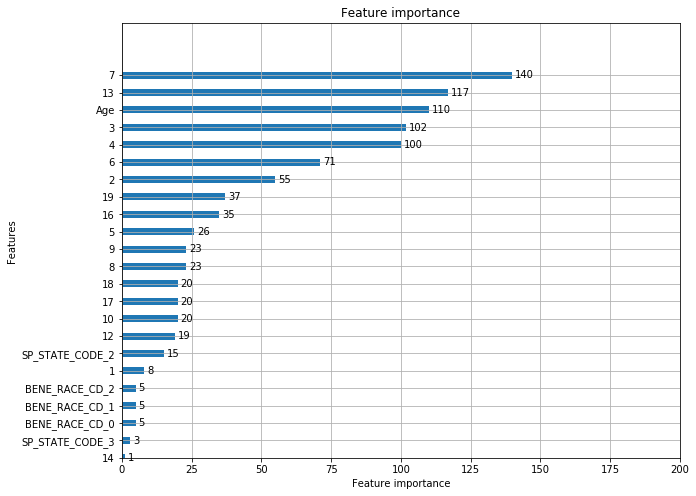

In [727]:
#Dimensionality reduction using feature importances
#features importance graph
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25,
                         ylabel='Features',
                         xlim = (0,200), ylim = (0,25), 
                         figsize = (10,8))
plt.show()

In [728]:
# For each feature of our dataset, the result of the following
# code snippet contains numbers of times a feature is used in a model.
sorted(gbm.feature_importances_,reverse=True)

[140,
 117,
 110,
 102,
 100,
 71,
 55,
 37,
 35,
 26,
 23,
 23,
 20,
 20,
 20,
 19,
 15,
 8,
 5,
 5,
 5,
 3,
 1,
 0,
 0,
 0,
 0,
 0]

In [729]:
# The code below aims to find where at least 85% 
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    if temp/total >= 0.85:
        print(feature,temp/total) # stop when we 
        break

23 0.85


In [730]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
auc_roc_0=str(roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC without dimensionality reduction: 
0.6177623463435079


Confusion matrix:
 [[3747 2064]
 [2758 2985]]


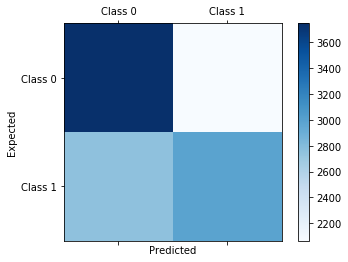

In [731]:
#Making predictions on the Test Set
y_pred = gbm.predict(X_test)

#Evaluating the predictions using a Confusion Matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [732]:
print(y_test.value_counts())

0    5811
1    5743
Name: HF_label, dtype: int64


In [735]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: {0:0.2f}'.format(recall))
print('precision: {0:0.2f}'.format(precision))

The accuracy of prediction is: 0.5826553574519647
The roc_auc_score of prediction is: 0.5822873771225251
The null acccuracy is: 0.502942703825515
recall: 0.52
precision: 0.59


In [700]:
#Drop features to reduce dimensionality to save training time and space
X = X.drop(['1', '10', '11', '12', '14', '15', '17', 'BENE_SEX',
       'SP_STATE_CODE_0', 'SP_STATE_CODE_1', 'SP_STATE_CODE_2',
       'SP_STATE_CODE_3', 'BENE_RACE_CD_0', 'BENE_RACE_CD_1',
       'BENE_RACE_CD_2'], axis=1)
X.columns

Index(['2', '3', '4', '5', '6', '7', '8', '9', '13', '16', '18', '19', 'Age'], dtype='object')

In [702]:
# Remake our test/train set with our reduced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

reduc_estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}

gridsearch = GridSearchCV(reduc_estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)
print('Best parameters found by grid search are:', gridsearch.best_params_)

C:\Users\barba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's l1: 0.498217	valid_0's binary_logloss: 0.689808	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496516	valid_0's binary_logloss: 0.686896	valid_0's auc: 0.601423
[3]	valid_0's l1: 0.494909	valid_0's binary_logloss: 0.684356	valid_0's auc: 0.605703
[4]	valid_0's l1: 0.493565	valid_0's binary_logloss: 0.682489	valid_0's auc: 0.605496
[5]	valid_0's l1: 0.492242	valid_0's binary_logloss: 0.680693	valid_0's auc: 0.607819
[6]	valid_0's l1: 0.491121	valid_0's binary_logloss: 0.679333	valid_0's auc: 0.607714
[7]	valid_0's l1: 0.490113	valid_0's binary_logloss: 0.678222	valid_0's auc: 0.60821
[8]	valid_0's l1: 0.48911	valid_0's binary_logloss: 0.677183	valid_0's auc: 0.608586
[9]	valid_0's l1: 0.488142	valid_0's binary_logloss: 0.676173	valid_0's auc: 0.610138
[10]	valid_0's l1: 0.487236	valid_0's binary_logloss: 0.675224	valid_0's auc: 0.61171
[11]	valid_0's l1: 0.486509	valid_0's binary_logloss: 0.674682	valid_0's auc: 0.6

[1]	valid_0's l1: 0.498155	valid_0's binary_logloss: 0.689673	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496459	valid_0's binary_logloss: 0.686797	valid_0's auc: 0.600335
[3]	valid_0's l1: 0.494989	valid_0's binary_logloss: 0.684509	valid_0's auc: 0.602786
[4]	valid_0's l1: 0.493675	valid_0's binary_logloss: 0.682628	valid_0's auc: 0.603726
[5]	valid_0's l1: 0.49245	valid_0's binary_logloss: 0.681005	valid_0's auc: 0.605443
[6]	valid_0's l1: 0.491183	valid_0's binary_logloss: 0.679302	valid_0's auc: 0.609471
[7]	valid_0's l1: 0.49021	valid_0's binary_logloss: 0.67819	valid_0's auc: 0.609996
[8]	valid_0's l1: 0.489179	valid_0's binary_logloss: 0.677018	valid_0's auc: 0.611347
[9]	valid_0's l1: 0.488291	valid_0's binary_logloss: 0.676116	valid_0's auc: 0.61191
[10]	valid_0's l1: 0.487432	valid_0's binary_logloss: 0.675257	valid_0's auc: 0.613316
[11]	valid_0's l1: 0.486651	valid_0's binary_logloss: 0.674466	valid_0's auc: 0.61

[1]	valid_0's l1: 0.498217	valid_0's binary_logloss: 0.689808	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496516	valid_0's binary_logloss: 0.686896	valid_0's auc: 0.601423
[3]	valid_0's l1: 0.494909	valid_0's binary_logloss: 0.684356	valid_0's auc: 0.605703
[4]	valid_0's l1: 0.493565	valid_0's binary_logloss: 0.682489	valid_0's auc: 0.605496
[5]	valid_0's l1: 0.492242	valid_0's binary_logloss: 0.680693	valid_0's auc: 0.607819
[6]	valid_0's l1: 0.491121	valid_0's binary_logloss: 0.679333	valid_0's auc: 0.607714
[7]	valid_0's l1: 0.490113	valid_0's binary_logloss: 0.678222	valid_0's auc: 0.60821
[8]	valid_0's l1: 0.48911	valid_0's binary_logloss: 0.677183	valid_0's auc: 0.608586
[9]	valid_0's l1: 0.488142	valid_0's binary_logloss: 0.676173	valid_0's auc: 0.610138
[10]	valid_0's l1: 0.487236	valid_0's binary_logloss: 0.675224	valid_0's auc: 0.61171
[11]	valid_0's l1: 0.486509	valid_0's binary_logloss: 0.674682	valid_0's auc: 0.6

[1]	valid_0's l1: 0.498057	valid_0's binary_logloss: 0.689489	valid_0's auc: 0.598617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496331	valid_0's binary_logloss: 0.686578	valid_0's auc: 0.600364
[3]	valid_0's l1: 0.494737	valid_0's binary_logloss: 0.684116	valid_0's auc: 0.603336
[4]	valid_0's l1: 0.493393	valid_0's binary_logloss: 0.682294	valid_0's auc: 0.603096
[5]	valid_0's l1: 0.492016	valid_0's binary_logloss: 0.680461	valid_0's auc: 0.605186
[6]	valid_0's l1: 0.490773	valid_0's binary_logloss: 0.678897	valid_0's auc: 0.607588
[7]	valid_0's l1: 0.489678	valid_0's binary_logloss: 0.677724	valid_0's auc: 0.608127
[8]	valid_0's l1: 0.488646	valid_0's binary_logloss: 0.676559	valid_0's auc: 0.610268
[9]	valid_0's l1: 0.487726	valid_0's binary_logloss: 0.675656	valid_0's auc: 0.610731
[10]	valid_0's l1: 0.486826	valid_0's binary_logloss: 0.674736	valid_0's auc: 0.612653
[11]	valid_0's l1: 0.486094	valid_0's binary_logloss: 0.674106	valid_0's auc: 

[1]	valid_0's l1: 0.498155	valid_0's binary_logloss: 0.689673	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496459	valid_0's binary_logloss: 0.686797	valid_0's auc: 0.600335
[3]	valid_0's l1: 0.494989	valid_0's binary_logloss: 0.684509	valid_0's auc: 0.602786
[4]	valid_0's l1: 0.493675	valid_0's binary_logloss: 0.682628	valid_0's auc: 0.603726
[5]	valid_0's l1: 0.49245	valid_0's binary_logloss: 0.681005	valid_0's auc: 0.605443
[6]	valid_0's l1: 0.491183	valid_0's binary_logloss: 0.679302	valid_0's auc: 0.609471
[7]	valid_0's l1: 0.49021	valid_0's binary_logloss: 0.67819	valid_0's auc: 0.609996
[8]	valid_0's l1: 0.489179	valid_0's binary_logloss: 0.677018	valid_0's auc: 0.611347
[9]	valid_0's l1: 0.488291	valid_0's binary_logloss: 0.676116	valid_0's auc: 0.61191
[10]	valid_0's l1: 0.487432	valid_0's binary_logloss: 0.675257	valid_0's auc: 0.613316
[11]	valid_0's l1: 0.486651	valid_0's binary_logloss: 0.674466	valid_0's auc: 0.61

[1]	valid_0's l1: 0.498155	valid_0's binary_logloss: 0.689673	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496459	valid_0's binary_logloss: 0.686797	valid_0's auc: 0.600335
[3]	valid_0's l1: 0.494989	valid_0's binary_logloss: 0.684509	valid_0's auc: 0.602786
[4]	valid_0's l1: 0.493675	valid_0's binary_logloss: 0.682628	valid_0's auc: 0.603726
[5]	valid_0's l1: 0.49245	valid_0's binary_logloss: 0.681005	valid_0's auc: 0.605443
[6]	valid_0's l1: 0.491183	valid_0's binary_logloss: 0.679302	valid_0's auc: 0.609471
[7]	valid_0's l1: 0.49021	valid_0's binary_logloss: 0.67819	valid_0's auc: 0.609996
[8]	valid_0's l1: 0.489179	valid_0's binary_logloss: 0.677018	valid_0's auc: 0.611347
[9]	valid_0's l1: 0.488291	valid_0's binary_logloss: 0.676116	valid_0's auc: 0.61191
[10]	valid_0's l1: 0.487432	valid_0's binary_logloss: 0.675257	valid_0's auc: 0.613316
[11]	valid_0's l1: 0.486651	valid_0's binary_logloss: 0.674466	valid_0's auc: 0.61

[26]	valid_0's l1: 0.479305	valid_0's binary_logloss: 0.67002	valid_0's auc: 0.617196
[27]	valid_0's l1: 0.479082	valid_0's binary_logloss: 0.670001	valid_0's auc: 0.617147
[28]	valid_0's l1: 0.478876	valid_0's binary_logloss: 0.66995	valid_0's auc: 0.617451
[29]	valid_0's l1: 0.47867	valid_0's binary_logloss: 0.669921	valid_0's auc: 0.617393
[30]	valid_0's l1: 0.478559	valid_0's binary_logloss: 0.670033	valid_0's auc: 0.617097
[31]	valid_0's l1: 0.478364	valid_0's binary_logloss: 0.669978	valid_0's auc: 0.617254
[32]	valid_0's l1: 0.478284	valid_0's binary_logloss: 0.669974	valid_0's auc: 0.617252
[33]	valid_0's l1: 0.478178	valid_0's binary_logloss: 0.670014	valid_0's auc: 0.617324
Early stopping, best iteration is:
[28]	valid_0's l1: 0.478876	valid_0's binary_logloss: 0.66995	valid_0's auc: 0.617451
[1]	valid_0's l1: 0.498155	valid_0's binary_logloss: 0.689673	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496459	valid_0's bi

[1]	valid_0's l1: 0.49777	valid_0's binary_logloss: 0.689042	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495693	valid_0's binary_logloss: 0.685626	valid_0's auc: 0.601094
[3]	valid_0's l1: 0.493775	valid_0's binary_logloss: 0.682764	valid_0's auc: 0.605882
[4]	valid_0's l1: 0.492269	valid_0's binary_logloss: 0.680814	valid_0's auc: 0.605259
[5]	valid_0's l1: 0.490659	valid_0's binary_logloss: 0.678767	valid_0's auc: 0.609021
[6]	valid_0's l1: 0.489411	valid_0's binary_logloss: 0.67745	valid_0's auc: 0.609219
[7]	valid_0's l1: 0.488258	valid_0's binary_logloss: 0.67634	valid_0's auc: 0.609444
[8]	valid_0's l1: 0.48725	valid_0's binary_logloss: 0.675404	valid_0's auc: 0.610006
[9]	valid_0's l1: 0.486358	valid_0's binary_logloss: 0.674784	valid_0's auc: 0.609873
[10]	valid_0's l1: 0.48539	valid_0's binary_logloss: 0.673891	valid_0's auc: 0.611802
[11]	valid_0's l1: 0.484703	valid_0's binary_logloss: 0.673594	valid_0's auc: 0.611

[1]	valid_0's l1: 0.497572	valid_0's binary_logloss: 0.688644	valid_0's auc: 0.598617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495455	valid_0's binary_logloss: 0.685219	valid_0's auc: 0.601861
[3]	valid_0's l1: 0.493609	valid_0's binary_logloss: 0.68254	valid_0's auc: 0.60367
[4]	valid_0's l1: 0.49199	valid_0's binary_logloss: 0.680504	valid_0's auc: 0.60379
[5]	valid_0's l1: 0.490438	valid_0's binary_logloss: 0.678516	valid_0's auc: 0.608411
[6]	valid_0's l1: 0.489105	valid_0's binary_logloss: 0.677136	valid_0's auc: 0.609208
[7]	valid_0's l1: 0.487968	valid_0's binary_logloss: 0.676032	valid_0's auc: 0.609916
[8]	valid_0's l1: 0.486821	valid_0's binary_logloss: 0.67489	valid_0's auc: 0.611791
[9]	valid_0's l1: 0.485845	valid_0's binary_logloss: 0.674113	valid_0's auc: 0.61258
[10]	valid_0's l1: 0.484944	valid_0's binary_logloss: 0.67342	valid_0's auc: 0.613403
[11]	valid_0's l1: 0.48425	valid_0's binary_logloss: 0.672951	valid_0's auc: 0.613587

[1]	valid_0's l1: 0.497693	valid_0's binary_logloss: 0.68887	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495645	valid_0's binary_logloss: 0.685543	valid_0's auc: 0.60021
[3]	valid_0's l1: 0.493917	valid_0's binary_logloss: 0.682986	valid_0's auc: 0.604497
[4]	valid_0's l1: 0.49228	valid_0's binary_logloss: 0.680756	valid_0's auc: 0.60848
[5]	valid_0's l1: 0.490705	valid_0's binary_logloss: 0.678647	valid_0's auc: 0.612895
[6]	valid_0's l1: 0.489495	valid_0's binary_logloss: 0.677302	valid_0's auc: 0.612686
[7]	valid_0's l1: 0.48832	valid_0's binary_logloss: 0.676136	valid_0's auc: 0.612575
[8]	valid_0's l1: 0.487229	valid_0's binary_logloss: 0.675007	valid_0's auc: 0.614149
[9]	valid_0's l1: 0.486287	valid_0's binary_logloss: 0.674217	valid_0's auc: 0.614513
[10]	valid_0's l1: 0.485389	valid_0's binary_logloss: 0.673424	valid_0's auc: 0.615209
[11]	valid_0's l1: 0.484644	valid_0's binary_logloss: 0.672843	valid_0's auc: 0.615

[1]	valid_0's l1: 0.49777	valid_0's binary_logloss: 0.689042	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495693	valid_0's binary_logloss: 0.685626	valid_0's auc: 0.601094
[3]	valid_0's l1: 0.493775	valid_0's binary_logloss: 0.682764	valid_0's auc: 0.605882
[4]	valid_0's l1: 0.492269	valid_0's binary_logloss: 0.680814	valid_0's auc: 0.605259
[5]	valid_0's l1: 0.490659	valid_0's binary_logloss: 0.678767	valid_0's auc: 0.609021
[6]	valid_0's l1: 0.489411	valid_0's binary_logloss: 0.67745	valid_0's auc: 0.609219
[7]	valid_0's l1: 0.488258	valid_0's binary_logloss: 0.67634	valid_0's auc: 0.609444
[8]	valid_0's l1: 0.48725	valid_0's binary_logloss: 0.675404	valid_0's auc: 0.610006
[9]	valid_0's l1: 0.486358	valid_0's binary_logloss: 0.674784	valid_0's auc: 0.609873
[10]	valid_0's l1: 0.48539	valid_0's binary_logloss: 0.673891	valid_0's auc: 0.611802
[11]	valid_0's l1: 0.484703	valid_0's binary_logloss: 0.673594	valid_0's auc: 0.611

[1]	valid_0's l1: 0.497572	valid_0's binary_logloss: 0.688644	valid_0's auc: 0.598617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495455	valid_0's binary_logloss: 0.685219	valid_0's auc: 0.601861
[3]	valid_0's l1: 0.493609	valid_0's binary_logloss: 0.68254	valid_0's auc: 0.60367
[4]	valid_0's l1: 0.49199	valid_0's binary_logloss: 0.680504	valid_0's auc: 0.60379
[5]	valid_0's l1: 0.490438	valid_0's binary_logloss: 0.678516	valid_0's auc: 0.608411
[6]	valid_0's l1: 0.489105	valid_0's binary_logloss: 0.677136	valid_0's auc: 0.609208
[7]	valid_0's l1: 0.487968	valid_0's binary_logloss: 0.676032	valid_0's auc: 0.609916
[8]	valid_0's l1: 0.486821	valid_0's binary_logloss: 0.67489	valid_0's auc: 0.611791
[9]	valid_0's l1: 0.485845	valid_0's binary_logloss: 0.674113	valid_0's auc: 0.61258
[10]	valid_0's l1: 0.484944	valid_0's binary_logloss: 0.67342	valid_0's auc: 0.613403
[11]	valid_0's l1: 0.48425	valid_0's binary_logloss: 0.672951	valid_0's auc: 0.613587

[27]	valid_0's l1: 0.477657	valid_0's binary_logloss: 0.66963	valid_0's auc: 0.618192
[28]	valid_0's l1: 0.477537	valid_0's binary_logloss: 0.66971	valid_0's auc: 0.618104
[29]	valid_0's l1: 0.47743	valid_0's binary_logloss: 0.66971	valid_0's auc: 0.618193
[30]	valid_0's l1: 0.477365	valid_0's binary_logloss: 0.669858	valid_0's auc: 0.617823
[31]	valid_0's l1: 0.47722	valid_0's binary_logloss: 0.669923	valid_0's auc: 0.617535
Early stopping, best iteration is:
[26]	valid_0's l1: 0.477772	valid_0's binary_logloss: 0.669551	valid_0's auc: 0.618436
[1]	valid_0's l1: 0.497693	valid_0's binary_logloss: 0.68887	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.495645	valid_0's binary_logloss: 0.685543	valid_0's auc: 0.60021
[3]	valid_0's l1: 0.493917	valid_0's binary_logloss: 0.682986	valid_0's auc: 0.604497
[4]	valid_0's l1: 0.49228	valid_0's binary_logloss: 0.680756	valid_0's auc: 0.60848
[5]	valid_0's l1: 0.490705	valid_0's binary_log

[1]	valid_0's l1: 0.497325	valid_0's binary_logloss: 0.688304	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494899	valid_0's binary_logloss: 0.684476	valid_0's auc: 0.601098
[3]	valid_0's l1: 0.492631	valid_0's binary_logloss: 0.681232	valid_0's auc: 0.606594
[4]	valid_0's l1: 0.490883	valid_0's binary_logloss: 0.679152	valid_0's auc: 0.606536
[5]	valid_0's l1: 0.489356	valid_0's binary_logloss: 0.677462	valid_0's auc: 0.607727
[6]	valid_0's l1: 0.48805	valid_0's binary_logloss: 0.676271	valid_0's auc: 0.607945
[7]	valid_0's l1: 0.48667	valid_0's binary_logloss: 0.674848	valid_0's auc: 0.611238
[8]	valid_0's l1: 0.485575	valid_0's binary_logloss: 0.674056	valid_0's auc: 0.611847
[9]	valid_0's l1: 0.484544	valid_0's binary_logloss: 0.673223	valid_0's auc: 0.613213
[10]	valid_0's l1: 0.483676	valid_0's binary_logloss: 0.672752	valid_0's auc: 0.614028
[11]	valid_0's l1: 0.482961	valid_0's binary_logloss: 0.672328	valid_0's auc: 0.

[1]	valid_0's l1: 0.497232	valid_0's binary_logloss: 0.688094	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494906	valid_0's binary_logloss: 0.684433	valid_0's auc: 0.601598
[3]	valid_0's l1: 0.492913	valid_0's binary_logloss: 0.68161	valid_0's auc: 0.607793
[4]	valid_0's l1: 0.491139	valid_0's binary_logloss: 0.679377	valid_0's auc: 0.6095
[5]	valid_0's l1: 0.489619	valid_0's binary_logloss: 0.677705	valid_0's auc: 0.609851
[6]	valid_0's l1: 0.488218	valid_0's binary_logloss: 0.676148	valid_0's auc: 0.612149
[7]	valid_0's l1: 0.486886	valid_0's binary_logloss: 0.674804	valid_0's auc: 0.614007
[8]	valid_0's l1: 0.485763	valid_0's binary_logloss: 0.673766	valid_0's auc: 0.615222
[9]	valid_0's l1: 0.484799	valid_0's binary_logloss: 0.672963	valid_0's auc: 0.616046
[10]	valid_0's l1: 0.483743	valid_0's binary_logloss: 0.671958	valid_0's auc: 0.61838
[11]	valid_0's l1: 0.482972	valid_0's binary_logloss: 0.67157	valid_0's auc: 0.618

[1]	valid_0's l1: 0.497325	valid_0's binary_logloss: 0.688304	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494899	valid_0's binary_logloss: 0.684476	valid_0's auc: 0.601098
[3]	valid_0's l1: 0.492631	valid_0's binary_logloss: 0.681232	valid_0's auc: 0.606594
[4]	valid_0's l1: 0.490883	valid_0's binary_logloss: 0.679152	valid_0's auc: 0.606536
[5]	valid_0's l1: 0.489356	valid_0's binary_logloss: 0.677462	valid_0's auc: 0.607727
[6]	valid_0's l1: 0.48805	valid_0's binary_logloss: 0.676271	valid_0's auc: 0.607945
[7]	valid_0's l1: 0.48667	valid_0's binary_logloss: 0.674848	valid_0's auc: 0.611238
[8]	valid_0's l1: 0.485575	valid_0's binary_logloss: 0.674056	valid_0's auc: 0.611847
[9]	valid_0's l1: 0.484544	valid_0's binary_logloss: 0.673223	valid_0's auc: 0.613213
[10]	valid_0's l1: 0.483676	valid_0's binary_logloss: 0.672752	valid_0's auc: 0.614028
[11]	valid_0's l1: 0.482961	valid_0's binary_logloss: 0.672328	valid_0's auc: 0.

[1]	valid_0's l1: 0.497086	valid_0's binary_logloss: 0.687827	valid_0's auc: 0.598617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494552	valid_0's binary_logloss: 0.683813	valid_0's auc: 0.60426
[3]	valid_0's l1: 0.492431	valid_0's binary_logloss: 0.680996	valid_0's auc: 0.604319
[4]	valid_0's l1: 0.490681	valid_0's binary_logloss: 0.678951	valid_0's auc: 0.605205
[5]	valid_0's l1: 0.489034	valid_0's binary_logloss: 0.677232	valid_0's auc: 0.606496
[6]	valid_0's l1: 0.487573	valid_0's binary_logloss: 0.67568	valid_0's auc: 0.609095
[7]	valid_0's l1: 0.486394	valid_0's binary_logloss: 0.674704	valid_0's auc: 0.609868
[8]	valid_0's l1: 0.485368	valid_0's binary_logloss: 0.673957	valid_0's auc: 0.610941
[9]	valid_0's l1: 0.484416	valid_0's binary_logloss: 0.673349	valid_0's auc: 0.61123
[10]	valid_0's l1: 0.483496	valid_0's binary_logloss: 0.672643	valid_0's auc: 0.612326
[11]	valid_0's l1: 0.482624	valid_0's binary_logloss: 0.672043	valid_0's auc: 0.6

[26]	valid_0's l1: 0.477346	valid_0's binary_logloss: 0.670714	valid_0's auc: 0.61552
[27]	valid_0's l1: 0.477192	valid_0's binary_logloss: 0.670751	valid_0's auc: 0.615593
[28]	valid_0's l1: 0.477001	valid_0's binary_logloss: 0.670751	valid_0's auc: 0.615611
[29]	valid_0's l1: 0.476851	valid_0's binary_logloss: 0.670771	valid_0's auc: 0.615513
Early stopping, best iteration is:
[24]	valid_0's l1: 0.477511	valid_0's binary_logloss: 0.670368	valid_0's auc: 0.616479
[1]	valid_0's l1: 0.497232	valid_0's binary_logloss: 0.688094	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494906	valid_0's binary_logloss: 0.684433	valid_0's auc: 0.601598
[3]	valid_0's l1: 0.492913	valid_0's binary_logloss: 0.68161	valid_0's auc: 0.607793
[4]	valid_0's l1: 0.491139	valid_0's binary_logloss: 0.679377	valid_0's auc: 0.6095
[5]	valid_0's l1: 0.489619	valid_0's binary_logloss: 0.677705	valid_0's auc: 0.609851
[6]	valid_0's l1: 0.488218	valid_0's binary

[17]	valid_0's l1: 0.479622	valid_0's binary_logloss: 0.669898	valid_0's auc: 0.619295
[18]	valid_0's l1: 0.479356	valid_0's binary_logloss: 0.669889	valid_0's auc: 0.619376
[19]	valid_0's l1: 0.478942	valid_0's binary_logloss: 0.669767	valid_0's auc: 0.619629
[20]	valid_0's l1: 0.478724	valid_0's binary_logloss: 0.669829	valid_0's auc: 0.619107
[21]	valid_0's l1: 0.478374	valid_0's binary_logloss: 0.669617	valid_0's auc: 0.619669
Early stopping, best iteration is:
[16]	valid_0's l1: 0.479973	valid_0's binary_logloss: 0.669882	valid_0's auc: 0.619704
[1]	valid_0's l1: 0.49688	valid_0's binary_logloss: 0.687595	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494157	valid_0's binary_logloss: 0.683459	valid_0's auc: 0.601157
[3]	valid_0's l1: 0.491602	valid_0's binary_logloss: 0.68	valid_0's auc: 0.606703
[4]	valid_0's l1: 0.489644	valid_0's binary_logloss: 0.677809	valid_0's auc: 0.607765
[5]	valid_0's l1: 0.488025	valid_0's binary

[1]	valid_0's l1: 0.496772	valid_0's binary_logloss: 0.687346	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494032	valid_0's binary_logloss: 0.683161	valid_0's auc: 0.60488
[3]	valid_0's l1: 0.491922	valid_0's binary_logloss: 0.680436	valid_0's auc: 0.605927
[4]	valid_0's l1: 0.489769	valid_0's binary_logloss: 0.677659	valid_0's auc: 0.6123
[5]	valid_0's l1: 0.488245	valid_0's binary_logloss: 0.676188	valid_0's auc: 0.611224
[6]	valid_0's l1: 0.486743	valid_0's binary_logloss: 0.674847	valid_0's auc: 0.612136
[7]	valid_0's l1: 0.485273	valid_0's binary_logloss: 0.673337	valid_0's auc: 0.615438
[8]	valid_0's l1: 0.484104	valid_0's binary_logloss: 0.672449	valid_0's auc: 0.615621
[9]	valid_0's l1: 0.483283	valid_0's binary_logloss: 0.67198	valid_0's auc: 0.615673
[10]	valid_0's l1: 0.482373	valid_0's binary_logloss: 0.671242	valid_0's auc: 0.616745
[11]	valid_0's l1: 0.481639	valid_0's binary_logloss: 0.67086	valid_0's auc: 0.617

[1]	valid_0's l1: 0.496602	valid_0's binary_logloss: 0.687039	valid_0's auc: 0.598617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493709	valid_0's binary_logloss: 0.682633	valid_0's auc: 0.604208
[3]	valid_0's l1: 0.491356	valid_0's binary_logloss: 0.679726	valid_0's auc: 0.604546
[4]	valid_0's l1: 0.489414	valid_0's binary_logloss: 0.677602	valid_0's auc: 0.606515
[5]	valid_0's l1: 0.487816	valid_0's binary_logloss: 0.676179	valid_0's auc: 0.607623
[6]	valid_0's l1: 0.486512	valid_0's binary_logloss: 0.675136	valid_0's auc: 0.608443
[7]	valid_0's l1: 0.485195	valid_0's binary_logloss: 0.673949	valid_0's auc: 0.610731
[8]	valid_0's l1: 0.483811	valid_0's binary_logloss: 0.672763	valid_0's auc: 0.613465
[9]	valid_0's l1: 0.482832	valid_0's binary_logloss: 0.67208	valid_0's auc: 0.614173
[10]	valid_0's l1: 0.482085	valid_0's binary_logloss: 0.671679	valid_0's auc: 0.61437
[11]	valid_0's l1: 0.481323	valid_0's binary_logloss: 0.671319	valid_0's auc: 0.

[1]	valid_0's l1: 0.49688	valid_0's binary_logloss: 0.687595	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.494157	valid_0's binary_logloss: 0.683459	valid_0's auc: 0.601157
[3]	valid_0's l1: 0.491602	valid_0's binary_logloss: 0.68	valid_0's auc: 0.606703
[4]	valid_0's l1: 0.489644	valid_0's binary_logloss: 0.677809	valid_0's auc: 0.607765
[5]	valid_0's l1: 0.488025	valid_0's binary_logloss: 0.676239	valid_0's auc: 0.608629
[6]	valid_0's l1: 0.486466	valid_0's binary_logloss: 0.674769	valid_0's auc: 0.610665
[7]	valid_0's l1: 0.485373	valid_0's binary_logloss: 0.674122	valid_0's auc: 0.610011
[8]	valid_0's l1: 0.484139	valid_0's binary_logloss: 0.67313	valid_0's auc: 0.611874
[9]	valid_0's l1: 0.483186	valid_0's binary_logloss: 0.672614	valid_0's auc: 0.612156
[10]	valid_0's l1: 0.482315	valid_0's binary_logloss: 0.672208	valid_0's auc: 0.613098
[11]	valid_0's l1: 0.481605	valid_0's binary_logloss: 0.671921	valid_0's auc: 0.6135

[1]	valid_0's l1: 0.496602	valid_0's binary_logloss: 0.687039	valid_0's auc: 0.598617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493709	valid_0's binary_logloss: 0.682633	valid_0's auc: 0.604208
[3]	valid_0's l1: 0.491356	valid_0's binary_logloss: 0.679726	valid_0's auc: 0.604546
[4]	valid_0's l1: 0.489414	valid_0's binary_logloss: 0.677602	valid_0's auc: 0.606515
[5]	valid_0's l1: 0.487816	valid_0's binary_logloss: 0.676179	valid_0's auc: 0.607623
[6]	valid_0's l1: 0.486512	valid_0's binary_logloss: 0.675136	valid_0's auc: 0.608443
[7]	valid_0's l1: 0.485195	valid_0's binary_logloss: 0.673949	valid_0's auc: 0.610731
[8]	valid_0's l1: 0.483811	valid_0's binary_logloss: 0.672763	valid_0's auc: 0.613465
[9]	valid_0's l1: 0.482832	valid_0's binary_logloss: 0.67208	valid_0's auc: 0.614173
[10]	valid_0's l1: 0.482085	valid_0's binary_logloss: 0.671679	valid_0's auc: 0.61437
[11]	valid_0's l1: 0.481323	valid_0's binary_logloss: 0.671319	valid_0's auc: 0.

[1]	valid_0's l1: 0.496435	valid_0's binary_logloss: 0.686915	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493413	valid_0's binary_logloss: 0.682513	valid_0's auc: 0.600892
[3]	valid_0's l1: 0.490672	valid_0's binary_logloss: 0.678964	valid_0's auc: 0.606912
[4]	valid_0's l1: 0.48876	valid_0's binary_logloss: 0.677121	valid_0's auc: 0.605397
[5]	valid_0's l1: 0.486925	valid_0's binary_logloss: 0.675434	valid_0's auc: 0.608061
[6]	valid_0's l1: 0.48564	valid_0's binary_logloss: 0.674721	valid_0's auc: 0.607492
[7]	valid_0's l1: 0.484424	valid_0's binary_logloss: 0.673907	valid_0's auc: 0.608958
[8]	valid_0's l1: 0.483091	valid_0's binary_logloss: 0.672784	valid_0's auc: 0.611904
[9]	valid_0's l1: 0.482099	valid_0's binary_logloss: 0.672196	valid_0's auc: 0.613084
[10]	valid_0's l1: 0.481398	valid_0's binary_logloss: 0.671923	valid_0's auc: 0.613662
[11]	valid_0's l1: 0.480603	valid_0's binary_logloss: 0.671616	valid_0's auc: 0.

[1]	valid_0's l1: 0.496312	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493238	valid_0's binary_logloss: 0.68209	valid_0's auc: 0.605184
[3]	valid_0's l1: 0.49081	valid_0's binary_logloss: 0.679075	valid_0's auc: 0.607917
[4]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.676467	valid_0's auc: 0.612803
[5]	valid_0's l1: 0.486979	valid_0's binary_logloss: 0.675035	valid_0's auc: 0.611943
[6]	valid_0's l1: 0.48557	valid_0's binary_logloss: 0.674039	valid_0's auc: 0.61179
[7]	valid_0's l1: 0.483904	valid_0's binary_logloss: 0.672292	valid_0's auc: 0.616407
[8]	valid_0's l1: 0.482891	valid_0's binary_logloss: 0.671692	valid_0's auc: 0.616449
[9]	valid_0's l1: 0.481892	valid_0's binary_logloss: 0.671094	valid_0's auc: 0.616571
[10]	valid_0's l1: 0.480922	valid_0's binary_logloss: 0.670441	valid_0's auc: 0.617951
[11]	valid_0's l1: 0.480255	valid_0's binary_logloss: 0.67007	valid_0's auc: 0.618

[1]	valid_0's l1: 0.496118	valid_0's binary_logloss: 0.686279	valid_0's auc: 0.598617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.492953	valid_0's binary_logloss: 0.681679	valid_0's auc: 0.603417
[3]	valid_0's l1: 0.490447	valid_0's binary_logloss: 0.678726	valid_0's auc: 0.604358
[4]	valid_0's l1: 0.48832	valid_0's binary_logloss: 0.676504	valid_0's auc: 0.606847
[5]	valid_0's l1: 0.48665	valid_0's binary_logloss: 0.675136	valid_0's auc: 0.608453
[6]	valid_0's l1: 0.485084	valid_0's binary_logloss: 0.673739	valid_0's auc: 0.611088
[7]	valid_0's l1: 0.483876	valid_0's binary_logloss: 0.673055	valid_0's auc: 0.611424
[8]	valid_0's l1: 0.482636	valid_0's binary_logloss: 0.672195	valid_0's auc: 0.612654
[9]	valid_0's l1: 0.481703	valid_0's binary_logloss: 0.671746	valid_0's auc: 0.613407
[10]	valid_0's l1: 0.481017	valid_0's binary_logloss: 0.671473	valid_0's auc: 0.613552
[11]	valid_0's l1: 0.480365	valid_0's binary_logloss: 0.671143	valid_0's auc: 0.

[1]	valid_0's l1: 0.496435	valid_0's binary_logloss: 0.686915	valid_0's auc: 0.591779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493413	valid_0's binary_logloss: 0.682513	valid_0's auc: 0.600892
[3]	valid_0's l1: 0.490672	valid_0's binary_logloss: 0.678964	valid_0's auc: 0.606912
[4]	valid_0's l1: 0.48876	valid_0's binary_logloss: 0.677121	valid_0's auc: 0.605397
[5]	valid_0's l1: 0.486925	valid_0's binary_logloss: 0.675434	valid_0's auc: 0.608061
[6]	valid_0's l1: 0.48564	valid_0's binary_logloss: 0.674721	valid_0's auc: 0.607492
[7]	valid_0's l1: 0.484424	valid_0's binary_logloss: 0.673907	valid_0's auc: 0.608958
[8]	valid_0's l1: 0.483091	valid_0's binary_logloss: 0.672784	valid_0's auc: 0.611904
[9]	valid_0's l1: 0.482099	valid_0's binary_logloss: 0.672196	valid_0's auc: 0.613084
[10]	valid_0's l1: 0.481398	valid_0's binary_logloss: 0.671923	valid_0's auc: 0.613662
[11]	valid_0's l1: 0.480603	valid_0's binary_logloss: 0.671616	valid_0's auc: 0.

[1]	valid_0's l1: 0.496312	valid_0's binary_logloss: 0.686624	valid_0's auc: 0.597275
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.493238	valid_0's binary_logloss: 0.68209	valid_0's auc: 0.605184
[3]	valid_0's l1: 0.49081	valid_0's binary_logloss: 0.679075	valid_0's auc: 0.607917
[4]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.676467	valid_0's auc: 0.612803
[5]	valid_0's l1: 0.486979	valid_0's binary_logloss: 0.675035	valid_0's auc: 0.611943
[6]	valid_0's l1: 0.48557	valid_0's binary_logloss: 0.674039	valid_0's auc: 0.61179
[7]	valid_0's l1: 0.483904	valid_0's binary_logloss: 0.672292	valid_0's auc: 0.616407
[8]	valid_0's l1: 0.482891	valid_0's binary_logloss: 0.671692	valid_0's auc: 0.616449
[9]	valid_0's l1: 0.481892	valid_0's binary_logloss: 0.671094	valid_0's auc: 0.616571
[10]	valid_0's l1: 0.480922	valid_0's binary_logloss: 0.670441	valid_0's auc: 0.617951
[11]	valid_0's l1: 0.480255	valid_0's binary_logloss: 0.67007	valid_0's auc: 0.618

[25]	valid_0's l1: 0.479963	valid_0's binary_logloss: 0.669881	valid_0's auc: 0.618342
[26]	valid_0's l1: 0.47964	valid_0's binary_logloss: 0.669664	valid_0's auc: 0.618858
Did not meet early stopping. Best iteration is:
[26]	valid_0's l1: 0.47964	valid_0's binary_logloss: 0.669664	valid_0's auc: 0.618858
Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 26}


In [720]:
gbm = lgb.LGBMClassifier(learning_rate = 0.1, metric = 'l1', 
                        n_estimators = 26)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's l1: 0.498183	valid_0's binary_logloss: 0.689718	valid_0's auc: 0.597218
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496581	valid_0's binary_logloss: 0.686998	valid_0's auc: 0.598594
[3]	valid_0's l1: 0.495086	valid_0's binary_logloss: 0.68464	valid_0's auc: 0.601837
[4]	valid_0's l1: 0.493731	valid_0's binary_logloss: 0.682716	valid_0's auc: 0.603222
[5]	valid_0's l1: 0.492422	valid_0's binary_logloss: 0.680885	valid_0's auc: 0.606706
[6]	valid_0's l1: 0.4914	valid_0's binary_logloss: 0.679588	valid_0's auc: 0.607821
[7]	valid_0's l1: 0.490324	valid_0's binary_logloss: 0.678298	valid_0's auc: 0.608676
[8]	valid_0's l1: 0.489275	valid_0's binary_logloss: 0.67701	valid_0's auc: 0.611342
[9]	valid_0's l1: 0.488404	valid_0's binary_logloss: 0.676094	valid_0's auc: 0.612104
[10]	valid_0's l1: 0.487546	valid_0's binary_logloss: 0.675224	valid_0's auc: 0.612587
[11]	valid_0's l1: 0.486714	valid_0's binary_logloss: 0.674327	valid_0's auc: 0.61

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=26, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

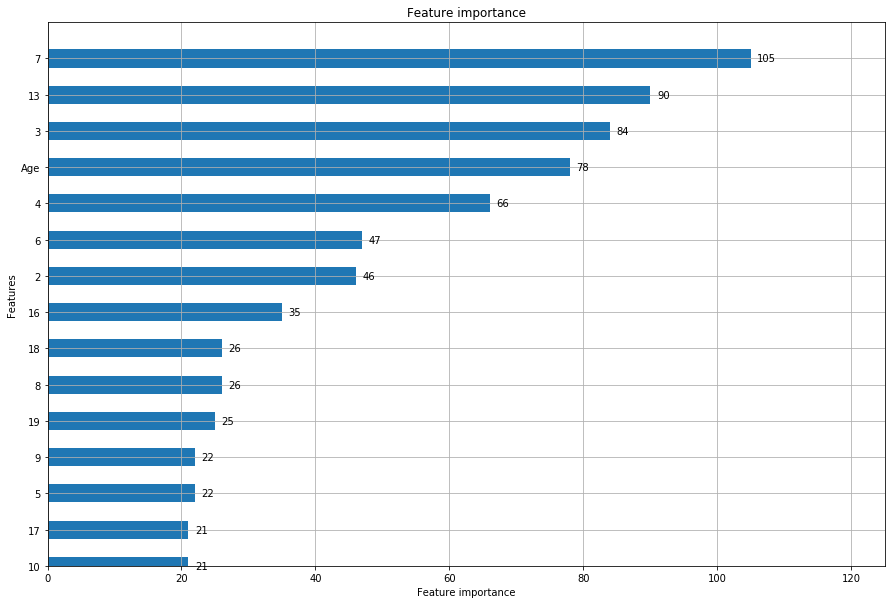

In [721]:
#Dimensionality reduction using feature importances
#features importance graph
ax = lgb.plot_importance(gbm, height = 0.5, 
                         max_num_features = 15,
                         ylabel='Features',
                         xlim = (0,125), ylim = (0,15), 
                         figsize = (15,10))
plt.show()

In [722]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
auc_roc_0=str(roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
print('AUC with dimensionality reduction: \n' + auc_roc_0)

AUC with dimensionality reduction: 
0.6203448562386844


In [736]:
print(y_test.value_counts())

0    5811
1    5743
Name: HF_label, dtype: int64


Confusion matrix:
 [[3747 2064]
 [2758 2985]]


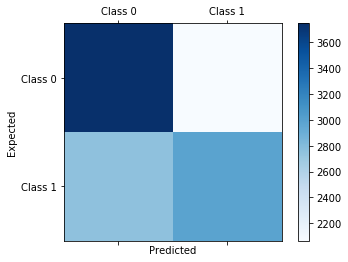

In [737]:
#Making predictions on the Test Set
y_pred = gbm.predict(X_test)

#Evaluating the predictions using a Confusion Matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [738]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: {0:0.2f}'.format(recall))
print('precision: {0:0.2f}'.format(precision))

The accuracy of prediction is: 0.5826553574519647
The roc_auc_score of prediction is: 0.5822873771225251
The null acccuracy is: 0.502942703825515
recall: 0.52
precision: 0.59


##### Keeping track of changes and results:
- Using Median(days_op_to_ip) column, this is for any IP event, not just CHF 4280, don't see value in using and feel that it is giving inaccurate results.  (recall: 0.99, precision: 0.72, acc: 0.8074, ROC AUC: 0.8408)
- After removing Median(days_op_to_ip) column (recall: 0.52, precision: 0.59, acc: 0.5827, ROC AUC: 0.6177)
- Only keep top 85% features (recall: 0.53, precision: 0.59, acc: 0.5826, ROC AUC: 0.62034)